# Disclaimer
This notebook starts out kind of well organized but quickly becomes rather messy.
It is not meant to be used as documentation, but rather as a tool to analyze the data and as such it contains many temporary solutions/values. Some values may even be inaccurate as they might be the result of some tests which were just left in as they were.

### Policy analysis
The point of this notebook is to analyze the privacy policies fetched with the spider.  
This presumes all the policies that are marked as successfully gathered in the report file are good, and only looks at said policies

In [1]:
import csv
import os
import json
import math

import justext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import langid
from readability import Readability
import textstat
    
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.cluster import DBSCAN
import sklearn.metrics

In [2]:
def site_name_from_file_name(file_name):
    return file_name[len("policy_"):len(file_name) - 4]

In [3]:
def make_policy_files():
    policy_files = []
    for filename in policy_file_names:
        policy_files.append(open(DATADIR + filename))
    return policy_files

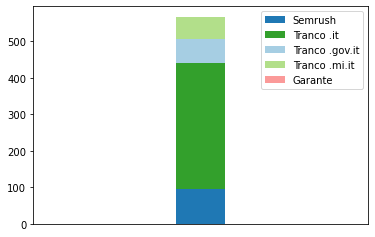

In [4]:
# Grafico lista siti
# colorbrewer2.org

plt.bar(0, 0, width = 5, color = 'w')
plt.bar(0, height = 95, color = '#1f78b4', label = 'Semrush') # Semrush 1f78b4 85
plt.bar(0, height = 346, bottom = 95, color = '#33a02c', label = 'Tranco .it') # Tranco .it 33a02c 356
plt.bar(0, height = 64, bottom = 95 + 346, color = '#a6cee3', label = 'Tranco .gov.it') # Tranco .gov.it a6cee3
plt.bar(0, height = 61, bottom = 95 + 346 + 64, color = '#b2df8a', label = 'Tranco .mi.it') # Tranco .mi.it b2df8a
plt.bar(0, height = 1, bottom = 95 + 346 + 64 + 61, color = '#fb9a99', label = 'Garante') # garante 984ea3

plt.legend()
plt.xticks([])
# plt.yticks([])
plt.savefig('images/composizionelista.svg')
plt.show()

## 1 Overview

In [5]:
DATADIR = "data/"
POLICY_FILE_PREFIX = "policy_"
REPORT_FILE_NAME = "crawl_report.json"

In [6]:
report_json = pd.read_json(DATADIR + REPORT_FILE_NAME)
# report_json

### 1.1 Success rate

In [7]:
# Recap
number_total = len(report_json)
print("Analyzed sites: " + str(number_total))

successful = report_json.loc[report_json["success"] == True]

# bl = []
# for l in report_json["policy_file"]:
#     try:
#         bl.append(len(open(DATADIR + l).read()) > 0)
#     except:
#         bl.append(False)

# s = pd.Series(bl)

# # successful = report_json.loc[(len(open(report_json["policy_file"]).read()) > 0)]
# successful = report_json[s.values]

number_successful = len(successful)
print("Successfully downloaded: " + str(number_successful))

print("Success rate: " + str(round((100 * number_successful / number_total), 1)) + "%")

failed_with_url = report_json.loc[pd.notna(report_json["policy_url"])
                                  & (report_json["success"] == False)]
print("Policy url found but no good policy found: " + str(len(failed_with_url)))
failed_with_url

Analyzed sites: 569
Successfully downloaded: 556
Success rate: 97.7%
Policy url found but no good policy found: 0


,url,policy_domain,policy_url,policy_file,uses_iubenda,success,ignore


In [8]:
# No policy at all

failed = report_json.loc[report_json["success"] == False]
print(len(failed))
failed

13


,url,policy_domain,policy_url,policy_file,uses_iubenda,success,ignore
33,https://procyclinggame.com,None,None,policy_procyclinggame.com.txt,False,False,False
45,https://zcsazzurrowebportal.com,None,None,policy_zcsazzurrowebportal.com.txt,False,False,False
52,https://librarymusicthemes.com,None,None,policy_librarymusicthemes.com.txt,False,False,False
53,https://fantasportal.com,None,None,policy_fantasportal.com.txt,False,False,False
55,https://www.flashscore.mobi/,None,None,policy_www.flashscore.mobi.txt,False,False,False
66,https://bonnovel.com,None,None,policy_bonnovel.com.txt,False,False,False
74,https://www.dv.is/,None,None,policy_www.dv.is.txt,False,False,False
211,https://cifreincomunespid.infocamere.it/casm/,None,None,policy_cifreincomunespid.infocamere.it.txt,False,False,False
330,https://www.ilportaledellautomobilista.it/web/...,None,None,policy_www.ilportaledellautomobilista.it.txt,False,False,False
413,https://hurawatch.it,None,None,policy_hurawatch.it.txt,False,False,False


In [9]:
successful = report_json.loc[report_json["success"] == True]
print(len(successful))

556


### 1.2 Sites overview

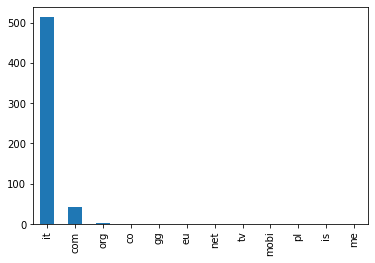

In [10]:
# TLDs

urls = report_json["url"]
ul = urls.tolist()

tlds = {}
for url in ul:
    slfssplit = (url.split("/")[2]).split(".")
    tld = slfssplit[len(slfssplit) - 1].split(":")[0]
#     tld = ((url.split(".")[len(url.split(".")) - 1]).split("/")[0]).split(":")[0]
    if tld in tlds.keys():
        tlds[tld] = tlds[tld] + 1
    else:
        tlds[tld] = 1
        
pd.Series(tlds).sort_values(ascending = False).plot.bar()
plt.savefig('images/tlds.svg')
plt.show()

## 2 Simple analysis

In [11]:
# Open policy files
policy_file_names = successful["policy_file"].tolist()

### Gov e PA

In [12]:
import re

def custom_gulpease(text):
    words = text.split()
    n_words = len(words)
    
    n_letters = 0
    for word in words:
        w_letters = 0
        l_word = word.lower()
        for c in l_word:
            if c in "qwertyuiopasdfghjklzxcvbnmàèéìòù0123456789":
                w_letters = w_letters + 1
        if w_letters == 0:
            n_words = n_words - 1
        else:
            n_letters = n_letters + w_letters
    n_sentences = len(re.split('[\.!?]\s+', text))
                
    return 89 + (((300 * n_sentences) - (10 * n_letters)) / n_words)

In [13]:

def get_pa_files():
    gov_pa_files = []
    
    for name in policy_file_names:
        if name[len(name) - 11: ] == ".gov.it.txt" \
            or name[len(name) - 15: ] == ".gov.it:443.txt" \
            or name == "policy_www.garanteprivacy.it.txt":
            gov_pa_files.append(open(DATADIR + name))
    #         print(name)
    
    return gov_pa_files

73
Beware different scales!
Median wordcount: 1179.0
Max wordcount: 3771


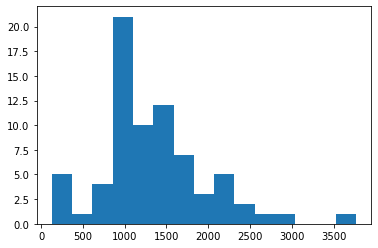

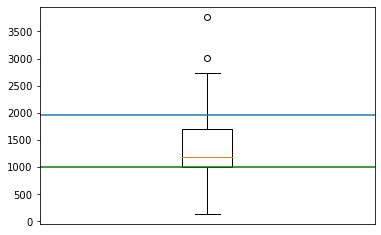


Higher score is easier to read
Hard to read texts: 46
as a percentage of total: 63.0%
Median gulpease index: 38.7090203685742
Texts above recommended level (8th grade rough italian equivalent) 100.0%


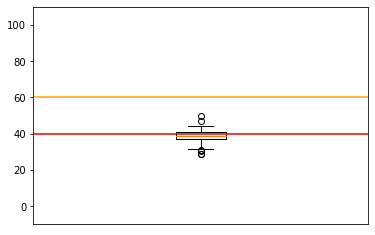

In [14]:
policy_files = get_pa_files()

# GARANTE
text_garante = open(DATADIR + 'policy_www.garanteprivacy.it.txt').read()

n_words = len(text_garante.split())
n_words_garante = n_words
n_words_garante = 997

# gulpease_garante = custom_gulpease(text_garante)
gulpease_garante = 40 # Calcolato sotto


# highest_wordcount = 0
# for file in policy_files:
#     file_wordcount = len(file.read().split())
#     if file_wordcount > highest_wordcount:
#         highest_wordcount = file_wordcount

policy_files = []
policy_files = get_pa_files()
print(len(policy_files))
        
wordcounts = []
max_wordcount = 0
for file in policy_files:
    wc = len(file.read().split())
    wordcounts.append(wc)
    if wc > max_wordcount:
        max_wordcount = wc 

#     plt.ylim(0, 15)

#     plt.ylim(0, 300) # !!!
print("Beware different scales!")

median_wordcount = np.median(wordcounts)
print("Median wordcount: " + str(median_wordcount))
print("Max wordcount: " + str(max_wordcount))

# plt.xlim(0, highest_wordcount * 1.1)
plt.hist(wordcounts, 15)
plt.savefig('images/wordcounthist' + '_gov' + '.svg')
plt.show()

# plt.ylim(-(highest_wordcount / 100), highest_wordcount * 1.1)
plt.boxplot(wordcounts)
plt.axhline(y = 1967) # Italian median wordcount
plt.axhline(y = n_words_garante, color = 'green', label = "Garante")
plt.xticks([])
plt.savefig('images/wordcountbox' + '_gov' + '.svg')
plt.show()

### GULP
texts = []
for file in get_pa_files():
    texts.append(file.read())

# Set box plot scale
plt.ylim(-10, 110)

ar_readability_scores = []

hard_to_read = 0
above_8th_grade = 0
avg_gulpease_index = 0.0
thresh_8th = 60
thresh_hard = 40
for policy_text in texts:
    gulpease = custom_gulpease(policy_text)

    avg_gulpease_index = avg_gulpease_index + float(gulpease)

    if int(gulpease) < thresh_8th:
        above_8th_grade = above_8th_grade + 1

    if gulpease < thresh_hard:
        hard_to_read = hard_to_read + 1
        
#     if gulpease < 30:
#         print(policy_text)

        
    ar_readability_scores.append(float(gulpease))

avg_gulpease_index = round((avg_gulpease_index / len(texts)), 1)
median_gulpease_index = np.median(ar_readability_scores)

print("\nHigher score is easier to read\nHard to read texts: " + str(hard_to_read) + "\n" +
    "as a percentage of total: "  + str(round((100 * hard_to_read / len(texts)), 1)) + "%\n" + 
     "Median gulpease index: " + str(median_gulpease_index) + "\n" +
     "Texts above recommended level (8th grade rough italian equivalent) " + str(round((100 * above_8th_grade / len(texts)), 1)) + "%")

    
plt.boxplot(ar_readability_scores)
plt.axhline(y = thresh_8th, color = 'orange', label = "Livello licenza media")
plt.axhline(y = thresh_hard, color = '#E50000', label = "Livello diploma superiore")
# plt.axhline(y = gulpease_garante, color = 'green', label = "Garante")
plt.xticks([])
# plt.legend()
plt.savefig('images/readabilitybox' + "_gov" + '.svg')
plt.show()

In [15]:
text_garante = open(DATADIR + 'policy_www.garanteprivacy.it.txt').read()

custom_gulpease(text_garante)
    
print(custom_gulpease(text_garante))

39.72216649949849


### 2.1 Language detection

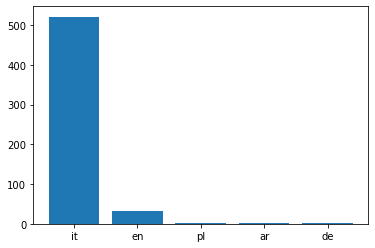

In [16]:
# Language detection
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

languages = {}
prevlen = 0
for file in policy_files:
    languages[file.name] = langid.classify(file.read())[0]
#     if languages[file.name] != "it" and (languages[file.name]) != "en":
#         print(languages[file.name])        
#         print(len(languages))
    if prevlen == len(languages):
        print(file.name)
    prevlen = len(languages)
        
plt.bar(pd.Series(languages).value_counts().keys(), pd.Series(languages).value_counts())
plt.savefig('images/langs.svg')
plt.show()

In [17]:
pd.Series(languages).value_counts()

it    521
en     32
pl      1
ar      1
de      1
dtype: int64

### Cookie vs privacy


In [18]:
policy_files = make_policy_files()

twice_co = 0
twice_pri = 0

for file in policy_files:
    cookie_ctr = 0
    privacy_ctr = 0
    
    for word in file.read().split():
        word = word.lower()
        if word == "cookie" or word == "cookies":
            cookie_ctr = cookie_ctr + 1
        elif word == "privacy":
            privacy_ctr = privacy_ctr + 1
        
    print("File name: " + file.name)
    print("Cookie: " + str(cookie_ctr))
    print("Privacy: " + str(privacy_ctr))
    if privacy_ctr != 0:
        ratio = cookie_ctr / privacy_ctr
    elif cookie_ctr == 0:
        ratio = 1
    else:
        ratio = math.inf
    print("Cookie / privacy: " + str(round(ratio * 100, 1)) + "%")
    if ratio > 2:
        twice_co = twice_co + 1
    elif ratio < 0.5:
        twice_pri = twice_pri + 1

print("")
print("Twice as many cookie: " + str(twice_co))
print("Twice as many privacy: " + str(twice_pri))

File name: data/policy_www.wikipedia.org.txt
Cookie: 8
Privacy: 69
Cookie / privacy: 11.6%
File name: data/policy_www.google.com.txt
Cookie: 29
Privacy: 47
Cookie / privacy: 61.7%
File name: data/policy_www.corriere.it.txt
Cookie: 90
Privacy: 12
Cookie / privacy: 750.0%
File name: data/policy_www.gazzetta.it.txt
Cookie: 94
Privacy: 14
Cookie / privacy: 671.4%
File name: data/policy_twitter.com.txt
Cookie: 2
Privacy: 19
Cookie / privacy: 10.5%
File name: data/policy_www.youtube.com.txt
Cookie: 29
Privacy: 47
Cookie / privacy: 61.7%
File name: data/policy_www.repubblica.it.txt
Cookie: 1
Privacy: 2
Cookie / privacy: 50.0%
File name: data/policy_www.google.it.txt
Cookie: 29
Privacy: 47
Cookie / privacy: 61.7%
File name: data/policy_search-hub.co.txt
Cookie: 6
Privacy: 14
Cookie / privacy: 42.9%
File name: data/policy_www.amazon.it.txt
Cookie: 19
Privacy: 23
Cookie / privacy: 82.6%
File name: data/policy_www.ansa.it.txt
Cookie: 9
Privacy: 8
Cookie / privacy: 112.5%
File name: data/policy_me

File name: data/policy_www.italiaonline.it.txt
Cookie: 7
Privacy: 5
Cookie / privacy: 140.0%
File name: data/policy_www.unimi.it.txt
Cookie: 2
Privacy: 1
Cookie / privacy: 200.0%
File name: data/policy_www.affaritaliani.it.txt
Cookie: 1
Privacy: 1
Cookie / privacy: 100.0%
File name: data/policy_www.unipi.it.txt
Cookie: 10
Privacy: 4
Cookie / privacy: 250.0%
File name: data/policy_www.notizie.it.txt
Cookie: 17
Privacy: 1
Cookie / privacy: 1700.0%
File name: data/policy_www.douglas.it.txt
Cookie: 11
Privacy: 7
Cookie / privacy: 157.1%
File name: data/policy_www.focus.it.txt
Cookie: 0
Privacy: 7
Cookie / privacy: 0.0%
File name: data/policy_www.milanotoday.it.txt
Cookie: 74
Privacy: 12
Cookie / privacy: 616.7%
File name: data/policy_www.unict.it.txt
Cookie: 0
Privacy: 6
Cookie / privacy: 0.0%
File name: data/policy_www.garr.it.txt
Cookie: 2
Privacy: 1
Cookie / privacy: 200.0%
File name: data/policy_www.varesenews.it.txt
Cookie: 11
Privacy: 45
Cookie / privacy: 24.4%
File name: data/policy

File name: data/policy_www.unisalento.it.txt
Cookie: 20
Privacy: 8
Cookie / privacy: 250.0%
File name: data/policy_cultura.gov.it.txt
Cookie: 8
Privacy: 3
Cookie / privacy: 266.7%
File name: data/policy_www.businessonline.it.txt
Cookie: 18
Privacy: 48
Cookie / privacy: 37.5%
File name: data/policy_www.spid.gov.it.txt
Cookie: 0
Privacy: 5
Cookie / privacy: 0.0%
File name: data/policy_www.lidl.it.txt
Cookie: 25
Privacy: 5
Cookie / privacy: 500.0%
File name: data/policy_www.miodottore.it.txt
Cookie: 0
Privacy: 1
Cookie / privacy: 0.0%
File name: data/policy_www.cure-naturali.it.txt
Cookie: 3
Privacy: 8
Cookie / privacy: 37.5%
File name: data/policy_fip.it.txt
Cookie: 51
Privacy: 1
Cookie / privacy: 5100.0%
File name: data/policy_www.lalaziosiamonoi.it.txt
Cookie: 4
Privacy: 4
Cookie / privacy: 100.0%
File name: data/policy_www.randstad.it.txt
Cookie: 0
Privacy: 4
Cookie / privacy: 0.0%
File name: data/policy_www.editorialedomani.it.txt
Cookie: 28
Privacy: 3
Cookie / privacy: 933.3%
File n

### 2.2 Detecting suspicious entries with DBSCAN
Some bad text will make it through the spider. With some clustering we can find suspicious texts and weed them out manually.  
Language detection is done before this in order to do clustering separately for each detected language.  
This step also detects policies from the same company on different sites i.e. wikimedia.org and wikipedia.org quite well.


Current language: en
METRICS:
[[1.         0.16165239 0.23648447 ... 0.12345536 0.13548157 0.17630907]
 [0.16165239 1.         0.16507959 ... 0.1955391  0.1531459  0.09007639]
 [0.23648447 0.16507959 1.         ... 0.09117512 0.07869364 0.09124961]
 ...
 [0.12345536 0.1955391  0.09117512 ... 1.         0.06396197 0.08826827]
 [0.13548157 0.1531459  0.07869364 ... 0.06396197 1.         0.09502935]
 [0.17630907 0.09007639 0.09124961 ... 0.08826827 0.09502935 1.        ]]
Found 5 clusters
Labels: 
[-1 -1 -1  0  1  0  0  0 -1 -1  0 -1  0 -1  0 -1  0  0  1 -1  0  0  2 -1
  3  3 -1  2 -1 -1 -1  0]


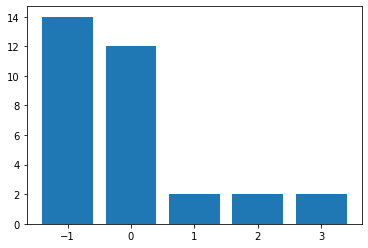


Cluster: -1 with 14 elements
data/policy_www.wikipedia.org.txt     Privacy policy From Meta, a Wikimedia project ...
data/policy_search-hub.co.txt         MENU Home OEMs/Carriers Developers Technology ...
data/policy_duckduckgo.com.txt        DuckDuckGo does not collect or share personal ...
data/policy_airporthandling.eu.txt    b'COOKIE POLICYRev. October 2022Airport Handli...
data/policy_bitly.com.txt             Skip Navigation Why Bitly? Bitly 101An introdu...
data/policy_chaturbate.com.txt        THE ACT OF MASTURBATING WHILE CHATTING ONLINE ...
data/policy_famiboards.com.txt        Forums TreehouseThe RoostPokémon CenterWarp Zo...
data/policy_www.netsdaily.com.txt     Skip to main content Cookie banner We use cook...
data/policy_freenem.com.txt           \nGDPR\n\n\nFreeNEM takes the GDPR extremely s...
data/policy_coggle.it.txt             Your Data, Sharing, and Privacy\n\nWe want to ...
data/policy_www.airbnb.it.txt         Privacy Policy\n\nFor a list of Privacy Polici...
da

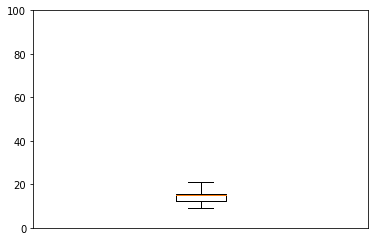


Cluster: 0 with 12 elements
data/policy_www.fandom.com.txt            FANDOM Fan Central Beta Games Anime Movies TV ...
data/policy_www.tiktok.com.txt            TikTok Web Cookies Policy\n\nLast updated: 16 ...
data/policy_www.reddit.com.txt            Advertisement Reddit and its partners use cook...
data/policy_www.libero.it.txt             Privacy & Terms Sign in Overview Privacy Polic...
data/policy_www.booking.com.txt           Skip to main content Select your language Sugg...
data/policy_onlyfans.com.txt              \nPRIVACY POLICY\n\nLast Modified: December 20...
data/policy_silverprice.org.txt           Skip to main content Main Menu SPX Charts Silv...
data/policy_telegram.org.txt              English Bahasa Indonesia Bahasa Melayu Deutsch...
data/policy_www.germancarforum.com.txt    We want you to understand how and why GermanCa...
data/policy_www.dailyfx.com.txt           PRIVACY NOTICE\nPRIVACY NOTICE\nAs part of our...
data/policy_kahoot.it.txt                 Modified:

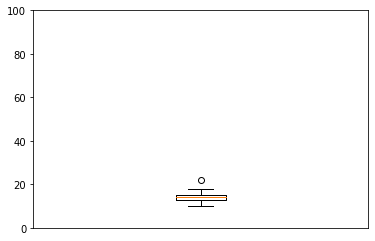


Cluster: 1 with 2 elements
data/policy_asura.gg.txt       \nPrivacy Policy\nPrivacy Policy\n\nThe follow...
data/policy_toonily.com.txt    \nPrivacy Policy\n\nThe following webpage outl...
Name: Text, dtype: object

Higher score is harder to read.
Hard to read texts: 0
as a percentage of total: 0.0%
Average grade level: 14.5
Texts above recommended level (8th grade) 100.0%
[13.0, 16.0]


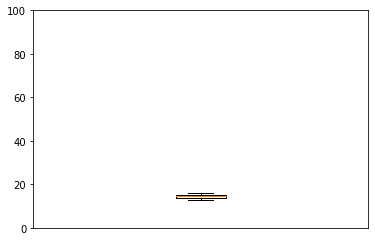


Cluster: 2 with 2 elements
data/policy_www.scoop.it.txt          Research and publish the best content. Get Sta...
data/policy_www.cybrary.it:443.txt    Training Library Start Your Career Certificati...
Name: Text, dtype: object

Higher score is harder to read.
Hard to read texts: 0
as a percentage of total: 0.0%
Average grade level: 16.5
Texts above recommended level (8th grade) 100.0%
[16.0, 17.0]


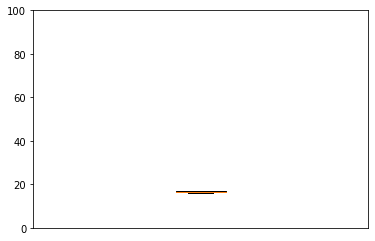


Cluster: 3 with 2 elements
data/policy_justpaste.it.txt    Privacy Policy 1. Introduction 1.1 We are comm...
data/policy_follow.it.txt       follow.it Privacy Policy\n\nLast Updated: Marc...
Name: Text, dtype: object

Higher score is harder to read.
Hard to read texts: 0
as a percentage of total: 0.0%
Average grade level: 13.5
Texts above recommended level (8th grade) 100.0%
[13.0, 14.0]


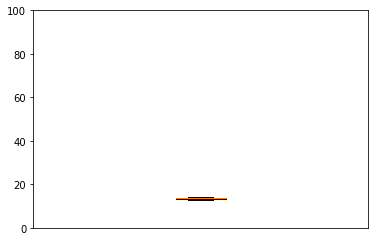



READABILTY FOR WHOLE LANGUAGE en

Higher score is harder to read.
Hard to read texts: 21
as a percentage of total: 65.6%
Average grade level: 14.6
Texts above recommended level (8th grade) 100.0%
Median score: 14.5


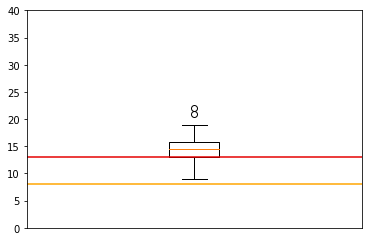


Current language: it
METRICS:
[[1.         0.19993166 0.17956196 ... 0.06969978 0.81529325 0.57884324]
 [0.19993166 1.         0.98544868 ... 0.13408197 0.23263795 0.13378266]
 [0.17956196 0.98544868 1.         ... 0.15895512 0.19913772 0.1303974 ]
 ...
 [0.06969978 0.13408197 0.15895512 ... 1.         0.11887667 0.07093034]
 [0.81529325 0.23263795 0.19913772 ... 0.11887667 1.         0.55894053]
 [0.57884324 0.13378266 0.1303974  ... 0.07093034 0.55894053 1.        ]]
Found 76 clusters
Labels: 
[ 0  1  1  0  0 -1  0  0 -1  0  2  3  4  3  5  2  2  6  2  7 -1  2  8 -1
  5 -1  2  0 -1  3  0 -1  0 -1 -1  9 10  0 11 12  2  8  0 13  3 -1  2 -1
 -1 -1 -1 -1 -1  8 14 15  0 16 -1 -1 11 17  0 18 19 20 -1 21 -1 -1 22 23
 23  2 24 25 26 27 -1 -1 -1 17 28 11 -1 29 14 -1 27 30  1  2 31 11 29 28
 -1 32 31 -1  0 -1  0 -1 -1 11 -1 33  7  1 -1 -1 31 -1 -1 -1 33 -1  1 -1
 -1  0 10  2 27 21 30  0 -1 11 -1 12 -1 14  2 11 33 -1 33 -1  0  0 30 33
 -1  2 -1 34 15  0 33 -1 -1 20 -1  0 -1 35 -1 -1 11 28 -1 22

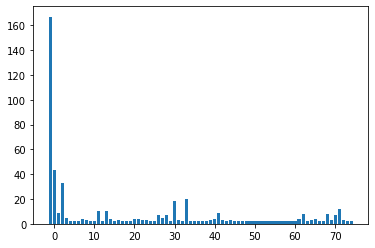


Cluster: -1 with 167 elements
data/policy_www.repubblica.it.txt            Abbonati Abbonati AbbonatiGedi Smile Menu di n...
data/policy_www.ansa.it.txt                  Social: Rss Facebook Twitter Linkedin Youtube ...
data/policy_www.sky.it.txt                   COOKIE POLICY\n(versione del\n14.07.2022)\nSky...
data/policy_www.messinanelpallone.it.txt     Ven 09 dicembre 2022Utenti online: 14 HomeAcr ...
data/policy_www.ilgiornale.it.txt            \nPrivacy Policy\nInformativa al trattamento d...
                                                                   ...                        
data/policy_www.maart.mi.it.txt              chi siamo contatti Maart magazine NEWSLETTER I...
data/policy_www.comune.cuggiono.mi.it.txt    Vai ai contenuti Vai al menu di navigazione Re...
data/policy_www.comune.settala.mi.it.txt     Passa al contenuto principale Passa alla barra...
data/policy_www.afor.mi.it.txt               Chi siamo Accreditamenti I nostri corsi Gestio...
data/policy_youtube

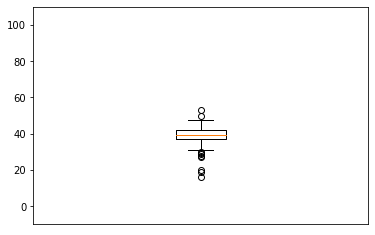


Cluster: 0 with 43 elements
data/policy_www.google.com.txt                      Privacy e termini Privacy e termini Accedi Int...
data/policy_twitter.com.txt                         \nSkip to main content\nInformativa sulla Priv...
data/policy_www.youtube.com.txt                     Privacy e termini Accedi Introduzione Norme su...
data/policy_www.google.it.txt                       Privacy e termini Privacy e termini Accedi Int...
data/policy_www.amazon.it.txt                       Continua senza accettare Selezione delle prefe...
data/policy_mediasetinfinity.mediaset.it.txt        \nINFORMATIVA PRIVACY\nNel seguente documento ...
data/policy_www.ebay.it.txt                         Passa al contenuto principale Servizio clienti...
data/policy_www.my-personaltrainer.it.txt           INFORMATIVA PRIVACYex articolo 13 del Regolame...
data/policy_www.giallozafferano.it.txt              INFORMATIVA PRIVACYex articolo 13 del Regolame...
data/policy_www.whatsapp.com.txt                    C

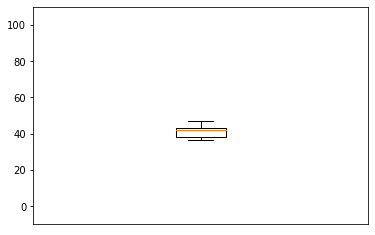


Cluster: 1 with 9 elements
data/policy_www.corriere.it.txt          desktop includes2013/SSI/notification/global.j...
data/policy_www.gazzetta.it.txt          desktop //js2.gazzettaobjects.it//notifiche/gl...
data/policy_www.la7.it.txt               LA7 LA7d TG LA7 Frequenze LA7 Programmi Guida ...
data/policy_www.iodonna.it.txt           HOMEPAGE Attualità Moda Bellezza Benessere Per...
data/policy_www.oggi.it.txt              Accedi\nRegistrati\nLogout\nIl tuo profilo Att...
data/policy_www.fcinter1908.it.txt       Questo sito contribuisce alla audience de Il t...
data/policy_www.amica.it.txt             Moda News Moda Fashion Story Star look Special...
data/policy_www.rcsmediagroup.it.txt     Cerca Tools Menu Tienimi aggiornato Contatti F...
data/policy_www.calcioefinanza.it.txt    Finanza Governance Media Stadi Marketing Sport...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 22.2%
Average gulpease index: 41.6
Texts above 

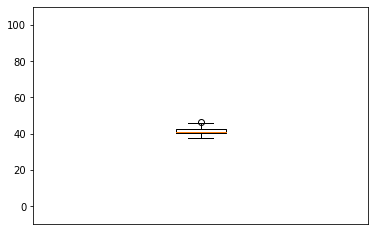


Cluster: 2 with 33 elements
data/policy_www.3bmeteo.com.txt               \nINFORMATIVA PRIVACY & COOKIE POLICY\n\nLa pr...
data/policy_www.mygpteam.com.txt              Informativa Privacy\nLo scopo del presente doc...
data/policy_www.fantacalcio.it.txt            Fantacalcio Serie A TIM Leghe Fantacalcio Seri...
data/policy_multiplayer.it.txt                Piattaforme TUTTE PC PLAYSTATION 5 PLAYSTATION...
data/policy_www.fanpage.it.txt                Privacy Policy di www.fanpage.it Questa Applic...
data/policy_www.ilmessaggero.it.txt           \nCookie Policy di ilmessaggero.it\n\nQuesto d...
data/policy_spunteblu.it.txt                  Home Raccontaci la tua storia Cristina&Luca Cr...
data/policy_www.ilgazzettino.it.txt           \nCookie Policy di ilgazzettino.it\n\nQuesto d...
data/policy_www.leggo.it.txt                  \nCookie Policy di leggo.it\n\nQuesto document...
data/policy_www.money.it.txt                  document.getElementById('search-input').focus(...
data/policy

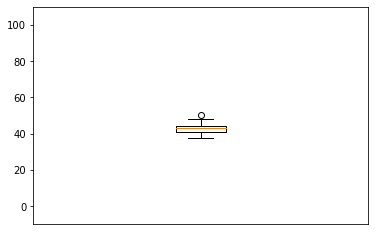


Cluster: 3 with 5 elements
data/policy_www.tuttojuve.com.txt          Privacy Policy\n\nIl GDPR (General Data Protec...
data/policy_www.tuttomercatoweb.com.txt    MenuSerie ASerie BSerie CCalcio EsteroQatar 20...
data/policy_www.tuttonapoli.net.txt        Privacy Policy\n\nIl GDPR (General Data Protec...
data/policy_www.milannews.it.txt           Privacy Policy\n\nIl GDPR (General Data Protec...
data/policy_www.lalaziosiamonoi.it.txt     Privacy Policy\n\nIl GDPR (General Data Protec...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.1, 41.6, 42.4, 42.9, 41.2]


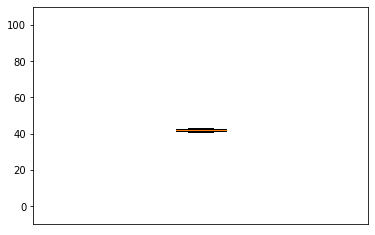


Cluster: 4 with 2 elements
data/policy_weather.com.txt           Passa al contenuto principaleAssistenza per ac...
data/policy_www.gettyimages.it.txt    Bacheche 0 Accedi Creative Editorial Sport Ent...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.2, 40.8]


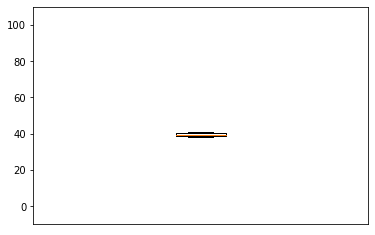


Cluster: 5 with 2 elements
data/policy_www.tuttosport.com.txt           Tuttosport.comTuttosport.com ABBONATI A €0,99 ...
data/policy_www.corrieredellosport.it.txt    Corriere dello Sport.itCorriere dello Sport.it...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 41.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.9, 41.6]


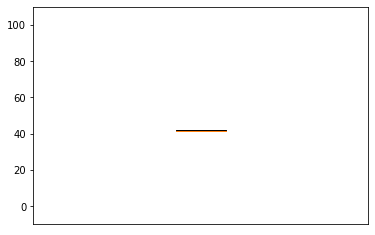


Cluster: 6 with 2 elements
data/policy_poste.it.txt                La versione del tuo browser non è aggiornata. ...
data/policy_www.posteitaliane.it.txt    Stai utilizzando una versione obsoleta di Inte...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[33.2, 46.2]


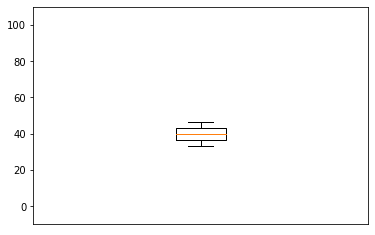


Cluster: 7 with 4 elements
data/policy_www.lastampa.it.txt          \nCookie Policy\n\nUltimo aggiornamento: Ottob...
data/policy_www.huffingtonpost.it.txt    \nCookie Policy\n\nUltimo aggiornamento: Ottob...
data/policy_www.deejay.it.txt            \nCookie Policy\n\nUltimo aggiornamento: Ottob...
data/policy_www.ilsecoloxix.it.txt       \nCookie Policy\n\nUltimo aggiornamento: Ottob...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 4
as a percentage of total: 100.0%
Average gulpease index: 38.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.0, 38.0, 38.0, 38.0]


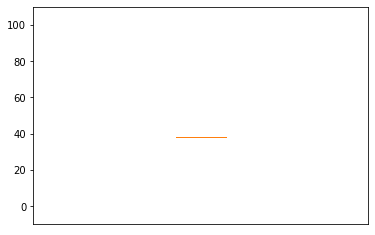


Cluster: 8 with 3 elements
data/policy_www.bing.com.txt         Informativa sulla privacy di Microsoft\nUltimo...
data/policy_outlook.live.com.txt     Informativa sulla privacy di Microsoft\nUltimo...
data/policy_www.microsoft.com.txt    Informativa sulla privacy di Microsoft\nUltimo...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 33.3%
Average gulpease index: 41.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.3, 42.4, 42.4]


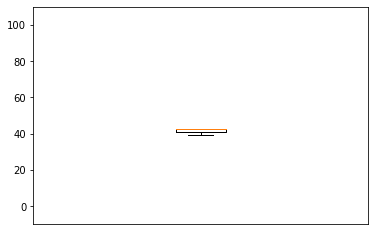


Cluster: 9 with 2 elements
data/policy_diretta.it.txt                  La tua privacy\n\nTrattiamo i vostri dati per ...
data/policy_www.giornaledibrescia.it.txt    ABBONATI Indice Stai leggendo: Il tuo profilo ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 40.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.5, 38.1]


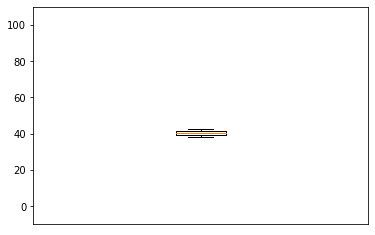


Cluster: 10 with 2 elements
data/policy_www.liberoquotidiano.it.txt    Cerca Più su questo argomento #Qatar2022 #Mano...
data/policy_www.iltempo.it.txt             Cerca Più su questo argomento Cerca CHI SIAMO ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.6, 42.8]


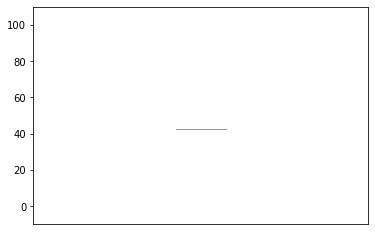


Cluster: 11 with 10 elements
data/policy_www.virgilio.it.txt         COOKIE POLICY DI ITALIAONLINE Gentile utente, ...
data/policy_www.paginegialle.it.txt     Le più cercateVedi tutte Farmacie Supermercati...
data/policy_quifinanza.it.txt           Informativa Privacy per i visitatori del sito ...
data/policy_dilei.it.txt                Informativa Privacy per i visitatori del sito ...
data/policy_www.paginebianche.it.txt    LIBEROVIRGILIOPAGINEGIALLEPGCASA PAGINEBIANCHE...
data/policy_siviaggia.it.txt            Informativa Privacy per i visitatori del sito ...
data/policy_www.italiaonline.it.txt     Soluzioni per le aziende IOL Advertising Corpo...
data/policy_www.supereva.it.txt         INFORMATIVA PRIVACY PER I VISITATORI DEL SITO ...
data/policy_blog.virgilio.it.txt        Informativa Privacy per i visitatori del sito ...
data/policy_www.buonissimo.it.txt       Informativa Privacy per i visitatori del sito ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read

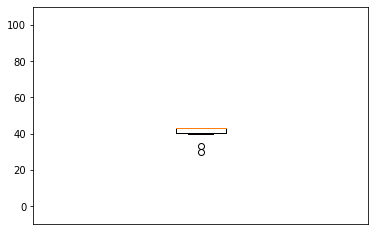


Cluster: 12 with 2 elements
data/policy_www.fcinternews.it.txt    tutte le notizie nerazzurre, aggiornate 24H Ve...
data/policy_www.inter.it.txt          Notizie Squadre Società OrganigrammaHall of Fa...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[43.8, 41.8]


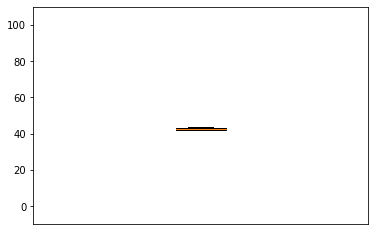


Cluster: 13 with 10 elements
data/policy_www.aranzulla.it:443.txt         \nPrivacy Policy di aranzulla.it\n\nQuesto Sit...
data/policy_meglio.it.txt                    \nPrivacy Policy di aforismi.meglio.it/\n\nQue...
data/policy_www.motociclismo.it.txt          Privacy Policy di Motociclismo.it Questo Sito ...
data/policy_www.rds.it.txt                   \nPrivacy Policy di rds.it\n\nQuesta Applicazi...
data/policy_www.ohga.it.txt                  Privacy Policy di www.ohga.it Questo Sito Web ...
data/policy_www.dire.it.txt                  \nPrivacy Policy di dire.it\n\nQuesta Applicaz...
data/policy_www.asianews.it.txt              \nPrivacy Policy di asianews.it\n\nQuesto Sito...
data/policy_consulentidellavoro.mi.it.txt    \nPrivacy Policy di consulentidellavoro.mi.it\...
data/policy_aji.mi.it.txt                    \nPrivacy Policy di aji.mi.it\n\nQuesto Sito W...
data/policy_www.pim.mi.it.txt                \nPrivacy Policy di pim.mi.it\n\nQuesta Applic...
Name: Text, dtype: o

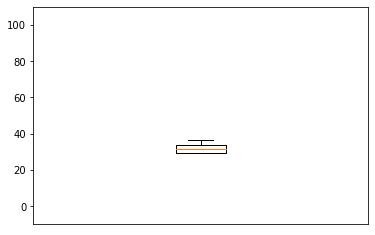


Cluster: 14 with 4 elements
data/policy_www.register.it.txt      Domini Domini Dominio .it gratis Trasferimenti...
data/policy_www.bakeca.it.txt        PreferitiAccediRegistratiPreferitiAccediRegist...
data/policy_www.enel.it.txt          Quick links Gestisci la tua fornitura Trova le...
data/policy_www.miodottore.it.txt    ati personali degli utenti\nChi è il titolare ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 25.0%
Average gulpease index: 39.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[40.2, 34.2, 40.0, 44.6]


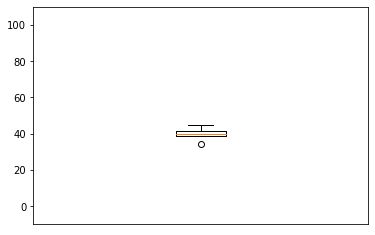


Cluster: 15 with 2 elements
data/policy_www.aruba.it.txt    Highlight AllMatch Case Match DiacriticsWhole ...
data/policy_www.pec.it.txt      Highlight AllMatch Case Match DiacriticsWhole ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 19.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[19.0, 19.0]


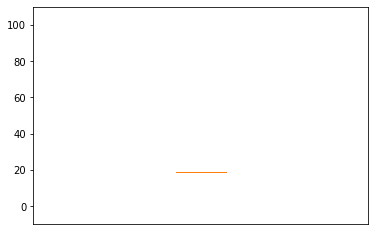


Cluster: 16 with 3 elements
data/policy_www.tim.it.txt          PRIVATI P.IVA e PMI AZIENDE E PA Fisso e Mobil...
data/policy_www.gruppotim.it.txt    La forza delle connessioni PreviousNext Chi si...
data/policy_tin.it.txt              PRIVATI P.IVA e PMI AZIENDE E PA Fisso e Mobil...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 100.0%
Average gulpease index: 35.2
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.2, 27.2, 39.2]


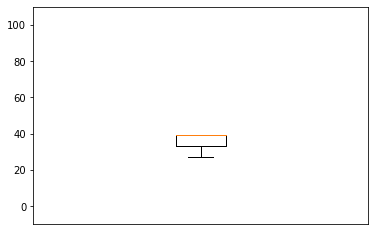


Cluster: 17 with 2 elements
data/policy_www.ibs.it.txt        Highlight AllMatch Case Match DiacriticsWhole ...
data/policy_www.fastweb.it.txt    Highlight AllMatch Case Match DiacriticsWhole ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 36.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[35.2, 37.4]


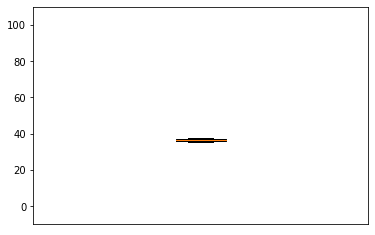


Cluster: 18 with 2 elements
data/policy_www.moto.it.txt        News Prove Elettrico MotoGP SBK Sport Viaggi V...
data/policy_www.automoto.it.txt    News Prove Elettrico F1 Saloni Listino Nuovo L...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.3, 41.6]


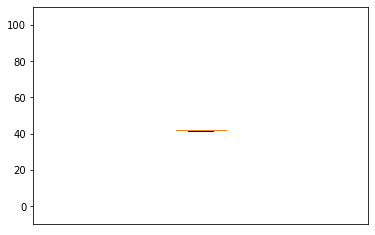


Cluster: 19 with 2 elements
data/policy_forumfree.it.txt          Privacy Policy\nForumFree di Walter Labbate, P...
data/policy_www.robadadonne.it.txt    \nInformativa Privacy\n\nMedia Prime S.r.l., c...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.3, 37.8]


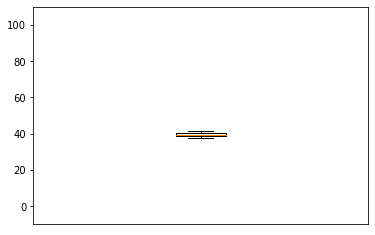


Cluster: 20 with 4 elements
data/policy_www.html.it.txt         Nessun risultato. Prova con un altro termine. ...
data/policy_www.pmi.it.txt          \nInformativa Privacy\n\nT-Mediahouse s.r.l, S...
data/policy_www.tvblog.it.txt       \nInformativa Privacy\n\nT-Mediahouse s.r.l, S...
data/policy_www.agrodolce.it.txt    \nInformativa Privacy\n\nT-Mediahouse s.r.l, S...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 4
as a percentage of total: 100.0%
Average gulpease index: 36.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[36.2, 36.4, 36.4, 36.4]


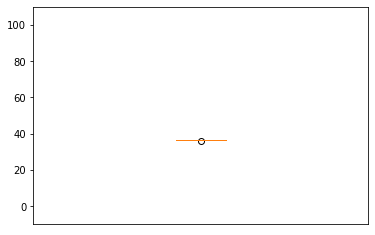


Cluster: 21 with 4 elements
data/policy_www.quattroruote.it.txt    Informativa privacy ai sensi del Regolamento G...
data/policy_www.linkiesta.it.txt       Accedi Ricerca per: Store\nLINKIESTA CLUB\nNew...
data/policy_www.domusweb.it.txt        Informativa privacy ai sensi del Regolamento G...
data/policy_www.dueruote.it.txt        Informativa privacy ai sensi del Regolamento G...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.9, 42.3, 42.9, 42.9]


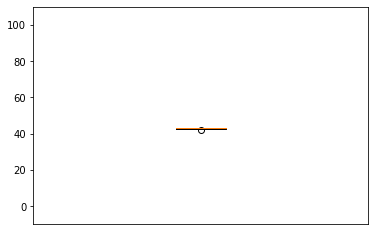


Cluster: 22 with 3 elements
data/policy_www.groupon.it.txt    If you're seeing this message, that means Java...
data/policy_www.ionos.it.txt      Termini e Condizioni T&C Condizioni Generali S...
data/policy_www.lidl.it.txt       No Javascript No Javascript Attiva Javascript ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 33.3%
Average gulpease index: 43.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[40.9, 48.1, 39.9]


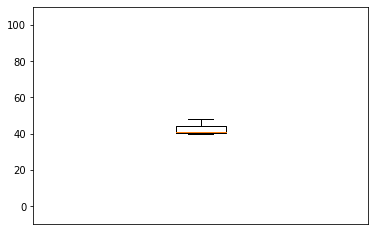


Cluster: 23 with 3 elements
data/policy_www.rai.it.txt             \nChi siamo e quali sono le nostre garanzie su...
data/policy_www.raiplay.it.txt         RAIPLAY TV RAIPLAY SOUND NEWS SPORT BAMBINI RA...
data/policy_www.raiplaysound.it.txt    RAIPLAY TV RAIPLAY SOUND NEWS SPORT BAMBINI RA...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 44.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[46.4, 44.0, 44.0]


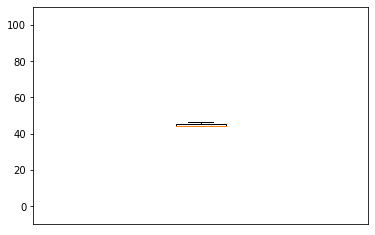


Cluster: 24 with 2 elements
data/policy_www.brt.it.txt    Spedire Ricevere Business Le filiali BRT-fermo...
data/policy_tnt.it.txt        Accedi a myTNT/\nRicaricaMenu Spedisci ora Tra...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 41.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[40.4, 42.6]


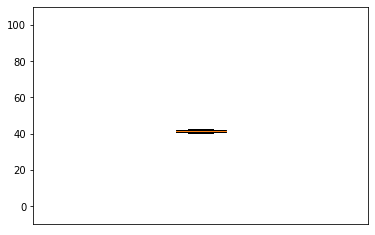


Cluster: 25 with 2 elements
data/policy_www.meteo.it.txt                  Previsioni Previsioni meteo Italia Previsioni ...
data/policy_www.centrometeoitaliano.it.txt    Questo sito contribuisce alla audience di Chi ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 41.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.5, 41.8]


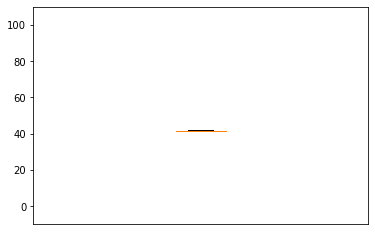


Cluster: 26 with 7 elements
data/policy_agenziaentrate.gov.it.txt         Navigazione Salta al contenuto Ministero dell'...
data/policy_www.adm.gov.it.txt                L'Agenzia delle Accise, Dogane e Monopoli Navi...
data/policy_www.agenziaentrate.gov.it.txt     Navigazione Salta al contenuto Ministero dell'...
data/policy_www.gdf.gov.it.txt                Informativa sul trattamento dei dati personali...
data/policy_www.agenziacoesione.gov.it.txt    Filtri Homepage L'Agenzia Brochure Agenzia (IT...
data/policy_www.agea.gov.it.txt               Chi siamo Contatti Comunicazione PEC Area cons...
data/policy_www.malattierare.gov.it.txt       Privacy Policy del Sito\nPERCHÈ QUESTO AVVISO\...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 4
as a percentage of total: 57.1%
Average gulpease index: 38.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[36.2, 36.9, 36.2, 42.6, 36.1, 40.3, 43.0]


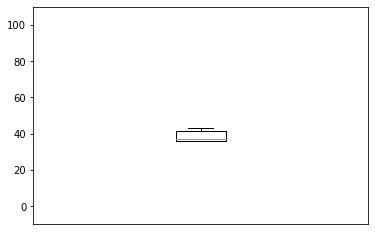


Cluster: 27 with 5 elements
data/policy_www.vanityfair.it.txt          Skip to main content Edizione Stati Uniti Spag...
data/policy_www.wired.it.txt               Skip to main content Privacy Scienza Economia ...
data/policy_www.vogue.it.txt               Skip to main content Edizione Arabia Australia...
data/policy_www.lacucinaitaliana.it.txt    Skip to main content Abbonamenti Newsletter Ce...
data/policy_www.gqitalia.it.txt            Skip to main content Edition Australia Brasil ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 5
as a percentage of total: 100.0%
Average gulpease index: 39.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.5, 39.7, 39.6, 39.6, 39.6]


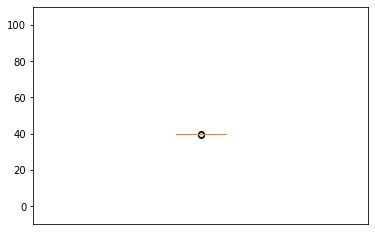


Cluster: 28 with 7 elements
data/policy_www.italotreno.it.txt         b"INFORMATIVA AGLI INTERESSATI AI SENSI DELLAR...
data/policy_www.laleggepertutti.it.txt    b"INFORMATIVA PRIVACYGENERAL DATA PROTECTION R...
data/policy_www.libraccio.it.txt          b'INFORMATIVA SUL TRATTAMENTO DEI DATI PERSONA...
data/policy_www.intervieweb.it:443.txt    b'INFORMATIVAsul trattamento dei dati personal...
data/policy_www.neosair.it.txt            b'Informativa al trattamento dei dati ex art. ...
data/policy_www.nicolaporro.it.txt        b"Lunifin SrlLargo F. Richini 2\\A20122 Milano...
data/policy_www.unicusano.it.txt          b"INFORMATIVA WEB PRIVACY AI SENSI DELLARTICOL...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 6
as a percentage of total: 85.7%
Average gulpease index: 36.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[34.9, 35.7, 36.2, 34.8, 35.8, 38.3, 40.5]


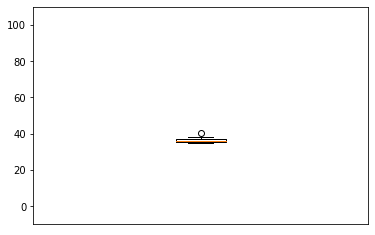


Cluster: 29 with 2 elements
data/policy_www.unieuro.it.txt     Ricevi in tempo i tuoi regali di Natale 🎁 Scop...
data/policy_www.euronics.it.txt    Skip to main contentSkip to footer content SOT...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 34.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[31.6, 37.0]


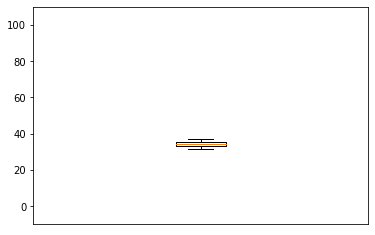


Cluster: 30 with 18 elements
data/policy_www.today.it.txt           Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.romatoday.it.txt       Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.milanotoday.it.txt     Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.napolitoday.it.txt     Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.palermotoday.it.txt    Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.padovaoggi.it.txt      Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.bolognatoday.it.txt    Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.bresciatoday.it.txt    Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.lecceprima.it.txt      Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.foggiatoday.it.txt     Informativa Privacy e Cookie Policy Siti Web C...
data/policy_www.torinotoday.it.txt     Informativa Privacy e Cookie Policy Siti 

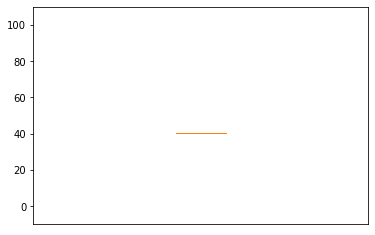


Cluster: 31 with 3 elements
data/policy_www.ilrestodelcarlino.it.txt    Privacy Robin\n\nInformativa Privacy ai sensi ...
data/policy_www.lanazione.it.txt            Privacy Robin\n\nInformativa Privacy ai sensi ...
data/policy_www.ilgiorno.it.txt             Privacy Robin\n\nInformativa Privacy ai sensi ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 100.0%
Average gulpease index: 39.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.9, 39.9, 39.9]


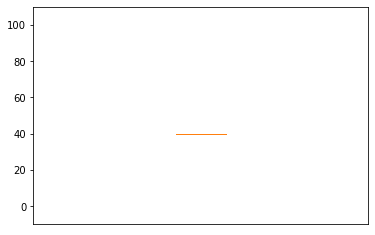


Cluster: 32 with 2 elements
data/policy_www.tomshw.it.txt         HOME Tom’s hardware Game Division MobileLabs C...
data/policy_www.spaziogames.it.txt    News Articoli Recensioni Anteprime Rubriche Sp...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.9, 42.9]


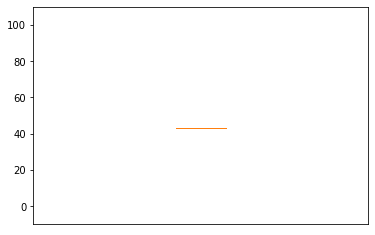


Cluster: 33 with 20 elements
data/policy_polimi.it.txt            Covid-19 Menu Il Politecnico Chi siamo Network...
data/policy_www.unipd.it.txt         Vai al contenuto Uniweb Area stampa Dipartimen...
data/policy_www.unimi.it.txt         Salta al contenuto principale Language switche...
data/policy_www.unipi.it.txt         Contenuto principale della paginaMenu di navig...
data/policy_www.unict.it.txt         Vai al contenuto principaleVai al menu di navi...
data/policy_unige.it.txt             Salta al contenuto principale Studia con noi C...
data/policy_www.unifi.it.txt         _SKIPNAVIGATION ITA | ENG Cerca nel sito Cerca...
data/policy_unica.it.txt             Vai al Contenuto Vai alla navigazione del sito...
data/policy_www.unimib.it.txt        Salta al contenuto principale ACCEDI A... Segr...
data/policy_unive.it.txt             Università Ca' Foscari Venezia Futuri studenti...
data/policy_www.uniba.it.txt         Vai al ContenutoVai alla navigazione del sito ...
data/policy_w

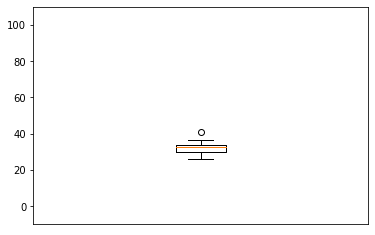


Cluster: 34 with 2 elements
data/policy_www.eolo.it.txt       Benvenuto Area Cliente Area Partner Codice cli...
data/policy_www.edenred.it.txt    Chi Siamo Chi Siamo Chi Siamo Edenred Sostenib...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 40.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.8, 41.3]


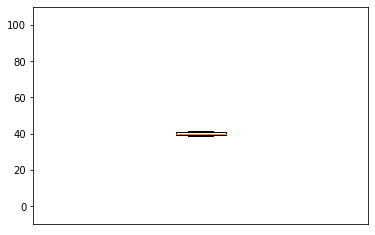


Cluster: 35 with 2 elements
data/policy_www.agid.gov.it:443.txt    Go to main content Go to site navigation Presi...
data/policy_www.spid.gov.it.txt        agid Italiano Italiano English Deutsch SPID Si...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 36.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[35.5, 37.8]


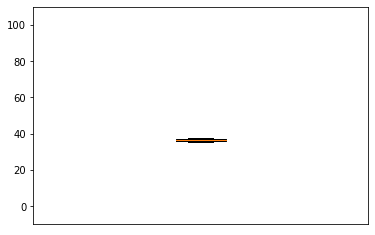


Cluster: 36 with 2 elements
data/policy_livesicilia.it.txt        Sezioni Tutte le notizie in tempo reale Cronac...
data/policy_www.blogsicilia.it.txt    Palermo Catania Siracusa Cronaca Politica Food...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.6, 37.1]


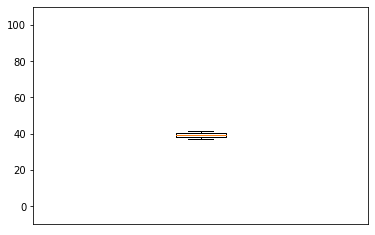


Cluster: 37 with 2 elements
data/policy_www.agi.it.txt     Search in primo piano Ponte ferro Monte bianco...
data/policy_www.eni.com.txt    \nPrivacy Policy\n\nL'informativa riguardante ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 37.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.3, 36.9]


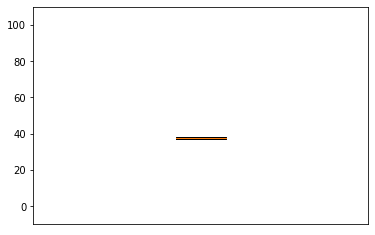


Cluster: 38 with 2 elements
data/policy_www.skyscanner.it.txt    Informativa sull'uso dei cookie\n\nlunedì 28 n...
data/policy_www.intel.it.txt         Passa al contenuto principale Login Nome utent...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[35.4, 43.8]


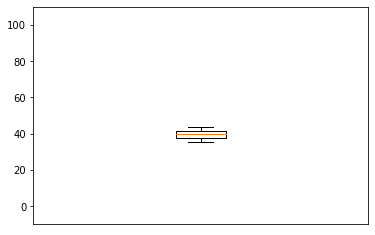


Cluster: 39 with 3 elements
data/policy_simplybook.me.txt    SimplyBook.me Iscriviti Menù Home Funzioni Fun...
data/policy_www.ovs.it.txt       cookie policy | OVS it IT Vai al contenuto pri...
data/policy_www.ing.it.txt       ATTENTO AL PHISHING! Daresti mai le tue chiavi...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 43.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[46.0, 41.9, 42.4]


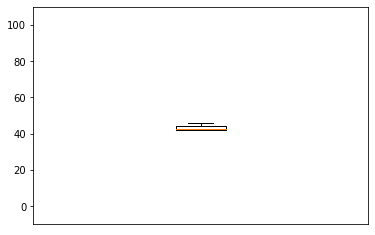


Cluster: 40 with 4 elements
data/policy_www.beniculturali.it.txt    Facebook Twitter Instagram Youtube E-mail Tele...
data/policy_cultura.gov.it.txt          Facebook Twitter Instagram Youtube E-mail Tele...
data/policy_opac.sbn.it.txt             Facebook Twitter Instagram Youtube E-mail Tele...
data/policy_artbonus.gov.it.txt         INFORMATIVA SUL TRATTAMENTO DEI DATI PERSONALI...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 75.0%
Average gulpease index: 39.1
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.1, 37.1, 37.1, 45.0]


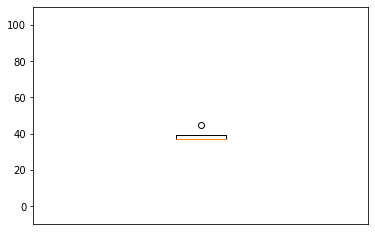


Cluster: 41 with 9 elements
data/policy_www.governo.it.txt                     Vai al ContenutoRaggiungi il piè di pagina MEN...
data/policy_www.protezionecivile.gov.it.txt        Vai al contenuto principaleRaggiungi il piè di...
data/policy_www.politicheeuropee.gov.it.txt        Questo sito utilizza cookie tecnici, analytics...
data/policy_www.informazioneeditoria.gov.it.txt    Vai al contenuto Vai alla navigazione del sito...
data/policy_www.politicheantidroga.gov.it.txt      Vai al contenuto Vai alla navigazione del sito...
data/policy_www.riformeistituzionali.gov.it.txt    Vai al contenuto Vai alla navigazione del sito...
data/policy_opencup.gov.it.txt                     Utilizzando questo sito accetti l'uso di cooki...
data/policy_www.rapportiparlamento.gov.it.txt      Vai al contenuto Vai alla navigazione del sito...
data/policy_www.programmagoverno.gov.it.txt        Vai al contenuto Vai alla navigazione del sito...
Name: Text, dtype: object

Higher score is easier to read
Hard

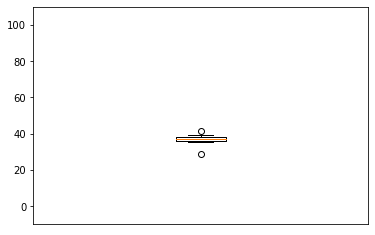


Cluster: 42 with 3 elements
data/policy_www.tpi.it.txt                 Leggi TPI direttamente dalla nostra app: facil...
data/policy_www.editorialedomani.it.txt    \nInformativa sul trattamento dei dati persona...
data/policy_www.informazione.it.txt        Gli altri portali Notizie a Confronto Comunica...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 33.3%
Average gulpease index: 39.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[36.7, 41.4, 41.6]


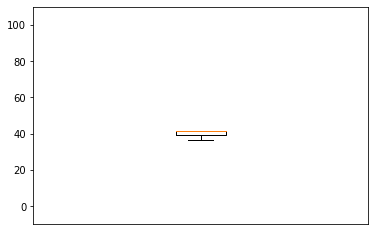


Cluster: 43 with 2 elements
data/policy_www.units.it.txt    Informativa sull'uso dei cookie sul sito web d...
data/policy_www.sissa.it.txt    \nCookie Policy\nCookie Policy\n\nQuesta pagin...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 42.1
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.3, 46.9]


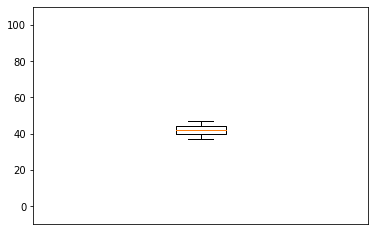


Cluster: 44 with 3 elements
data/policy_www.sella.it.txt          \n\nInformativa Cookie\n(REGOLAMENTO UE 2016/6...
data/policy_www.vinted.it.txt         \nInformativa sui cookie\n \nData ultimo aggio...
data/policy_www.lottomatica.it.txt    Informativa Cookie\n\nBenvenuto in www.lottoma...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 33.3%
Average gulpease index: 43.6
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[46.2, 45.9, 38.7]


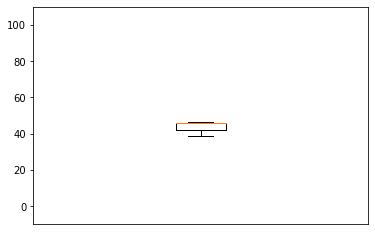


Cluster: 45 with 2 elements
data/policy_www.superguidatv.it.txt    Home Guida TV Ora in Tv Pomeriggio in Tv Oggi ...
data/policy_www.filmtv.it.txt          Espandi menu FilmTv Registrati oppure effettua...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.5, 44.2]


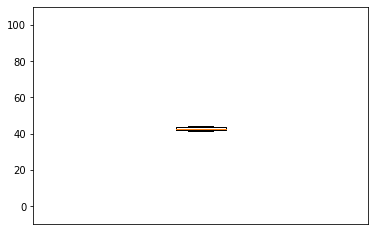


Cluster: 46 with 2 elements
data/policy_www.calciomercato.it.txt    Primo piano Tutte le notizie Mercato Esclusive...
data/policy_www.nanopress.it.txt        Sign in News Cronaca Politica Ambiente Spettac...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[40.0, 39.8]


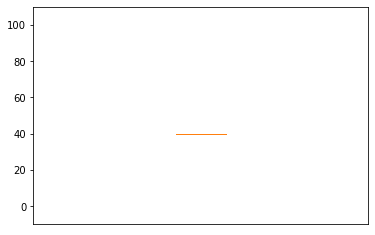


Cluster: 47 with 2 elements
data/policy_www.luiss.it.txt            Informativa sul trattamento dei dati di naviga...
data/policy_www.secoloditalia.it.txt    Chi siamo Sostienici Edicola Registrati Accedi...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 40.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[40.6, 39.5]


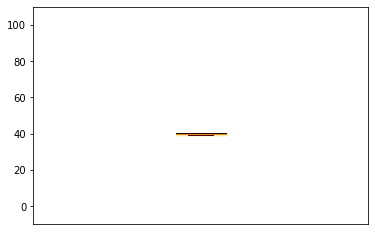


Cluster: 48 with 2 elements
data/policy_www.gazzettaufficiale.it.txt    Home la gazzetta ufficiale guida all'uso f.a.q...
data/policy_www.garanteprivacy.it.txt       Ultimo aggiornamento: 27 luglio 2021.\n\nVEDI ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.0, 38.1]


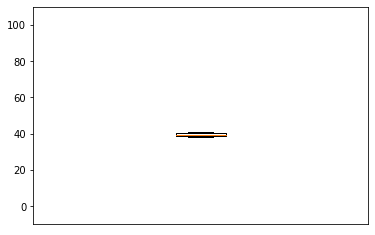


Cluster: 49 with 2 elements
data/policy_www.cronachemaceratesi.it.txt    CHI SIAMO Redazione Licenza sui contenuti Priv...
data/policy_libreriamo.it.txt                Vai al contenuto Libri Poesie Frasi Arte Fotog...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 42.8
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.5, 46.0]


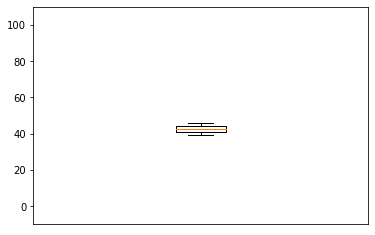


Cluster: 50 with 2 elements
data/policy_www.rinascente.it:443.txt    You need to enable JavaScript to run this app....
data/policy_www.gamestop.it:443.txt      Cerca Cerca GS Deals Negozi Servizio clienti C...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.7, 40.7]


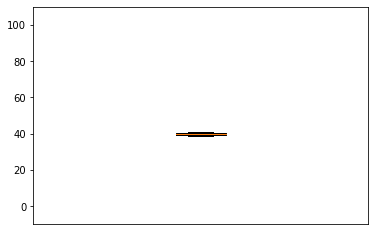


Cluster: 51 with 2 elements
data/policy_www.larena.it.txt                 Edizione digitale Newsletter Segnala Necrologi...
data/policy_www.ilgiornaledivicenza.it.txt    Edizione digitale Newsletter Segnala Necrologi...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.5, 42.6]


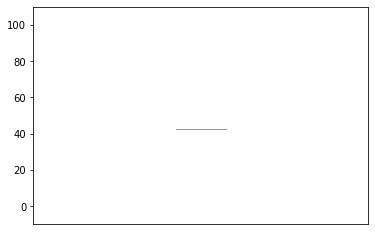


Cluster: 52 with 2 elements
data/policy_www.badtaste.it.txt              Cinema TV Casa Alò Podcast News Speciali Recen...
data/policy_www.tecnicadellascuola.it.txt     Disclaimer\n\n1. Regole Generali e definizion...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 41.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.2, 41.4]


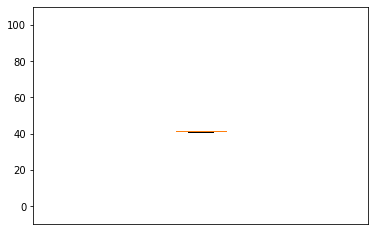


Cluster: 53 with 2 elements
data/policy_www.ipsoa.it.txt                      Privacy e cookie policy INFORMATIVA PER IL TRA...
data/policy_www.comune.abbiategrasso.mi.it.txt    Questo sito web utilizza cookie tecnici necess...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 38.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.0, 37.8]


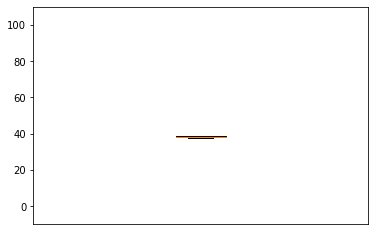


Cluster: 54 with 2 elements
data/policy_www.cinefilos.it.txt    Film 2019 2020 2021 2022 2023 2024 2025 Film N...
data/policy_www.tvserial.it.txt     Passa alla navigazione primaria Passa al conte...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 43.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.8, 45.0]


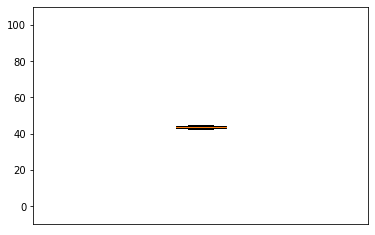


Cluster: 55 with 2 elements
data/policy_web.unisa.it.txt                   skip to main content Cerca persona Search Engl...
data/policy_www.ministeroturismo.gov.it.txt    Ricerca per: Menu Il Ministero Ministro Daniel...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 28.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[25.4, 31.2]


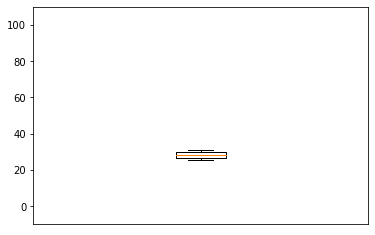


Cluster: 56 with 2 elements
data/policy_www.finanze.it.txt        b"INFORMATIVA SUL TRATTAMENTOhttps://www.finan...
data/policy_www.finanze.gov.it.txt    b"INFORMATIVA SUL TRATTAMENTOhttps://www.finan...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 32.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[32.9, 32.9]


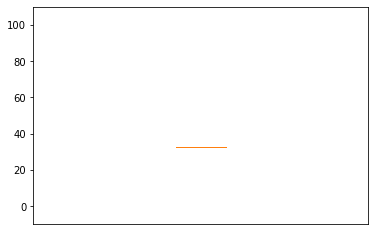


Cluster: 57 with 2 elements
data/policy_www.ecodibergamo.it.txt         Cerca nel sito PUBBLICITÀ ABBONAMENTI NECROLOG...
data/policy_www.laprovinciadicomo.it.txt    Cerca nel sito PUBBLICITÀ ABBONAMENTI NECROLOG...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 0
as a percentage of total: 0.0%
Average gulpease index: 42.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.4, 42.4]


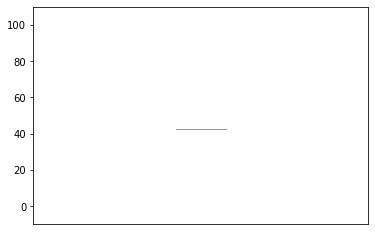


Cluster: 58 with 2 elements
data/policy_www.lavoro.gov.it.txt              \nServizi\nURP online\n\nStudi e Statistiche\n...
data/policy_integrazionemigranti.gov.it.txt    NOTE LEGALI\n\nIl portale www.integrazionemigr...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[36.1, 43.7]


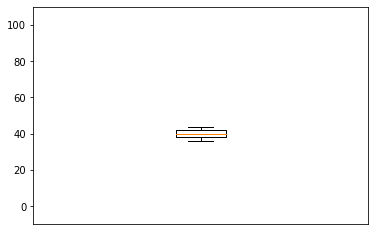


Cluster: 59 with 2 elements
data/policy_www.camera.it.txt             Salta al contenuto principale Social media pol...
data/policy_www.unioncamere.gov.it.txt    Salta al contenuto principale Menu hamburgher ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 35.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.2, 33.1]


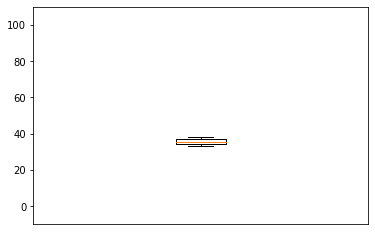


Cluster: 60 with 2 elements
data/policy_agenziaentrateriscossione.gov.it.txt    Vai al contenuto |\nVai al menu principale |\n...
data/policy_agenziariscossione.gov.it.txt           Vai al contenuto |\nVai al menu principale |\n...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 38.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.5, 38.5]


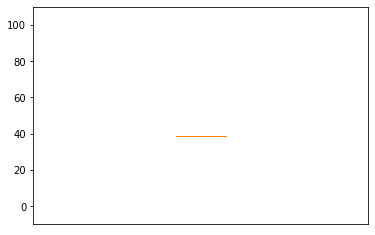


Cluster: 61 with 4 elements
data/policy_innovazione.gov.it.txt         Vai al contenuto principaleVai al footer Gover...
data/policy_padigitale2026.gov.it.txt      Menù principaleVai al contenuto principaleVai ...
data/policy_auu.gov.it.txt                 Dipartimento per le politiche della famiglia D...
data/policy_identitadigitale.gov.it.txt    Vai al contenuto principaleVai al footer Dipar...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 75.0%
Average gulpease index: 38.9
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.8, 36.9, 41.7, 39.1]


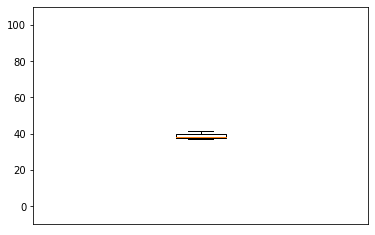


Cluster: 62 with 8 elements
data/policy_www.funzionepubblica.gov.it.txt      Vai al ContenutoRaggiungi il piè di pagina MEN...
data/policy_partecipa.gov.it.txt                 Questo sito utilizza cookies. Se continui la n...
data/policy_consulentipubblici.dfp.gov.it.txt    Questo sito utilizza cookies tecnici ma, altre...
data/policy_open.gov.it.txt                      \nPremessa\n\nIl Dipartimento per la Funzione ...
data/policy_competenzedigitali.gov.it.txt        Privacy\n\nIn questa pagina si descrivono le m...
data/policy_performance.gov.it.txt               Salta al contenuto principale MENU Chiudi menu...
data/policy_www.perlapa.gov.it.txt               Questo sito utilizza cookies tecnici ma, altre...
data/policy_lavoropubblico.gov.it.txt            Governo Italiano Presidenza del Consiglio dei ...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 6
as a percentage of total: 75.0%
Average gulpease index: 38.1
Texts above recommended level (8th gra

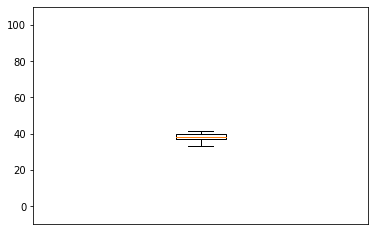


Cluster: 63 with 2 elements
data/policy_www.rna.gov.it.txt      INFORMATIVA SUL TRATTAMENTO DEI DATI PERSONALI...
data/policy_uibm.mise.gov.it.txt    Il sito usa cookie per offrire un servizio mig...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.4
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.6, 41.2]


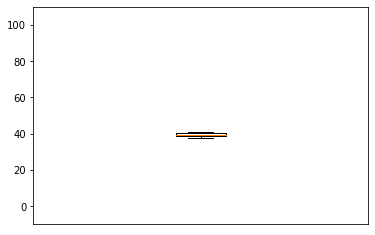


Cluster: 64 with 3 elements
data/policy_www.istruzioneer.gov.it.txt    Skip to content +39 051 37851 direzione-emilia...
data/policy_cert-agid.gov.it.txt           Vai al contenuto Vai alla navigazione del sito...
data/policy_sicurezzait.gov.it.txt         Privacy Policy\nInformativa sul trattamento de...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 100.0%
Average gulpease index: 38.3
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.7, 37.8, 39.4]


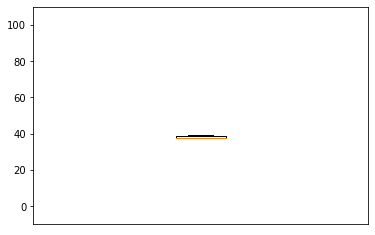


Cluster: 65 with 4 elements
data/policy_www.politichegiovanili.gov.it.txt               \n\nIl Dipartimento per le Politiche Giovanili...
data/policy_scelgoilserviziocivile.gov.it.txt               \nPrivacy Policy\n\nPrivacy\n\nIl Dipartimento...
data/policy_www.serviziocivile.gov.it.txt                   \nPrivacy Policy\n\nIl Dipartimento per le Pol...
data/policy_politichegiovanilieserviziocivile.gov.it.txt    \nPrivacy Policy\n\nIl Dipartimento per le Pol...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 4
as a percentage of total: 100.0%
Average gulpease index: 39.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[39.2, 38.8, 38.9, 38.9]


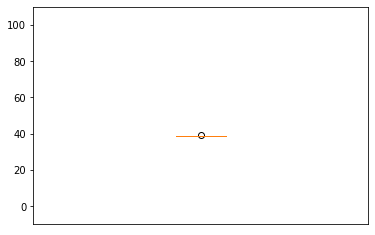


Cluster: 66 with 2 elements
data/policy_opencoesione.gov.it.txt              Scrivi a OpenCoesione News RSS Open Data Engli...
data/policy_www.fascicolosanitario.gov.it.txt    Salta al contenuto principale Agenzia per l'It...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 38.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[40.9, 36.0]


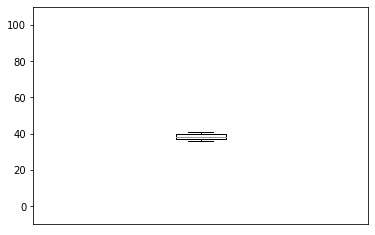


Cluster: 67 with 2 elements
data/policy_www.csirt.gov.it.txt    Privacy Policy\nInformazioni sul trattamento d...
data/policy_www.acn.gov.it.txt      Agenzia per laCybersicurezza Nazionale Seguici...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 37.0
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.6, 36.3]


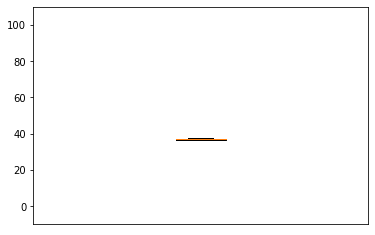


Cluster: 68 with 8 elements
data/policy_www.comune.corbetta.mi.it.txt          Regione Lombardia Comune di Corbetta Seguici s...
data/policy_www.comune.parabiago.mi.it.txt         Regione Lombardia Accedi ai servizi Città di P...
data/policy_www.comune.cassanodadda.mi.it.txt      Benvenuto nel\nportale della Città di Cassano ...
data/policy_www.comune.lacchiarella.mi.it.txt      Passa al contenuto principale Passa alla barra...
data/policy_www.comune.trezzosulladda.mi.it.txt    Vai al ContenutoRaggiungi il piè di pagina Hom...
data/policy_www.comune.cesano-boscone.mi.it.txt    Messaggio per utenti con sintetizzatori vocali...
data/policy_www.comune.vapriodadda.mi.it.txt       Eventi Uffici Trasparenza Comune Albo Online A...
data/policy_www.comune.pioltello.mi.it.txt         Questo sito utilizza cookie tecnici, analytics...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 8
as a percentage of total: 100.0%
Average gulpease index: 34.9
Texts above recommend

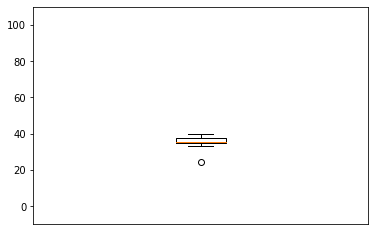


Cluster: 69 with 3 elements
data/policy_www.policlinico.mi.it.txt       \nInformativa al paziente sul trattamento dei ...
data/policy_ordinearchitetti.mi.it.txt      Caricamento... Serve aiuto? Serve aiuto? Lo St...
data/policy_www.istitutotumori.mi.it.txt    Navigazione Salta al contenuto Regione Lombard...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 66.7%
Average gulpease index: 39.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.9, 41.1, 39.0]


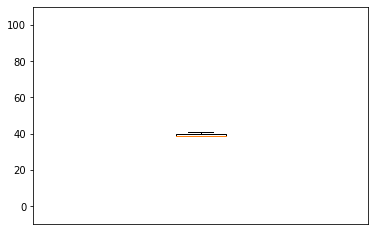


Cluster: 70 with 7 elements
data/policy_comune.magenta.mi.it.txt                \n\nCookie\n\nLa presente Cookie Policy costit...
data/policy_comune.garbagnate-milanese.mi.it.txt    Amministrazione Sindaco Giunta Comunale Consig...
data/policy_comune.cesate.mi.it.txt                 Questo sito utilizza solo cookie tecnici e ana...
data/policy_comune.sedriano.mi.it.txt               Questo sito utilizza solo cookie tecnici e ana...
data/policy_comune.dairago.mi.it.txt                Questo sito utilizza solo cookie tecnici e ana...
data/policy_comune.vizzolopredabissi.mi.it.txt      Amministrazione Sindaco Consiglio Comunale Giu...
data/policy_comune.vanzaghello.mi.it.txt            Questo sito utilizza solo cookie tecnici e ana...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 42.9%
Average gulpease index: 39.2
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[42.5, 40.3, 42.3, 34.3, 38.2, 41.0, 36.0]

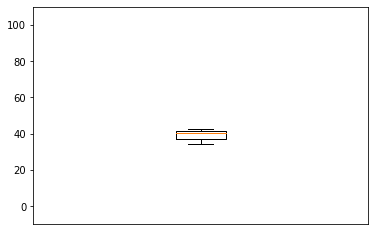


Cluster: 71 with 12 elements
data/policy_www.comune.peschieraborromeo.mi.it.txt    Regione Lombardia Città di Peschiera Borromeo ...
data/policy_www.comune.baranzate.mi.it.txt            \nPrivacy Policy Sito su format Municipium\n\n...
data/policy_www.comune.lainate.mi.it.txt              Regione Lombardia Comune di Lainate Seguici su...
data/policy_www.comune.melzo.mi.it.txt                Regione Lombardia Comune di Melzo - Città Metr...
data/policy_www.comune.cormano.mi.it.txt              Regione Lombardia Comune di Cormano Seguici su...
data/policy_www.comune.binasco.mi.it.txt              Regione Lombardia Comune di Binasco Seguici su...
data/policy_www.comune.gessate.mi.it.txt              Regione Lombardia Comune di Gessate Seguici su...
data/policy_www.comune.inzago.mi.it.txt               Regione Lombardia Comune di Inzago Seguici su ...
data/policy_www.comune.buccinasco.mi.it.txt           Regione Lombardia Comune di Buccinasco Seguici...
data/policy_www.comune.assago.mi.i

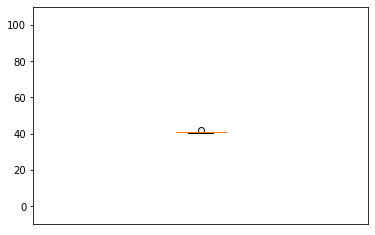


Cluster: 72 with 3 elements
data/policy_comune.bollate.mi.it.txt       Salta al contenuto Albo Pretorio Statuto Comun...
data/policy_www.comune.ozzero.mi.it.txt    bubblejoomlalockstar-fulltelegramuser Vai al C...
data/policy_comune.vanzago.mi.it.txt       Salta al contenuto Cerca per: HOME IL COMUNE O...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 3
as a percentage of total: 100.0%
Average gulpease index: 36.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[37.5, 38.8, 33.9]


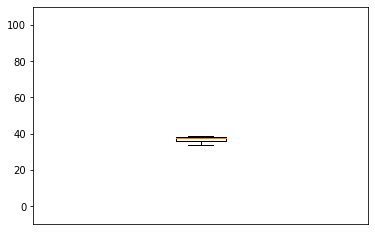


Cluster: 73 with 2 elements
data/policy_www.comune.mediglia.mi.it.txt           Regione Lombardia Accedi all'area personale Co...
data/policy_www.comune.cusano-milanino.mi.it.txt    vai al contenuto principale Regione Lombardia–...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 2
as a percentage of total: 100.0%
Average gulpease index: 38.7
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[38.3, 39.1]


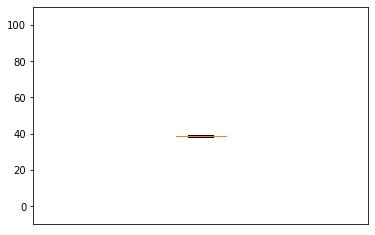


Cluster: 74 with 2 elements
data/policy_www.comune.novate-milanese.mi.it.txt     Comune di Novate Milanese venerdì 9 dicembre 2...
data/policy_www.comune.poglianomilanese.mi.it.txt    Regione Lombardia Home Aree Tematiche Aree Tem...
Name: Text, dtype: object

Higher score is easier to read
Hard to read texts: 1
as a percentage of total: 50.0%
Average gulpease index: 39.5
Texts above recommended level (8th grade rough italian equivalent) 100.0%
[41.3, 37.7]


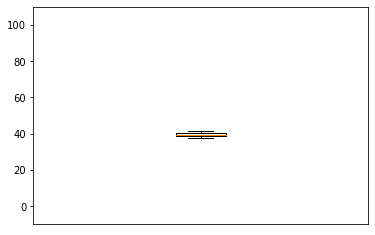



READABILTY FOR WHOLE LANGUAGE it

Higher score is easier to read
Hard to read texts: 211
as a percentage of total: 40.5%
Average gulpease index: 40.2
Texts above recommended level (8th grade rough italian equivalent) 100.0%
Median score: 41.110891740704176


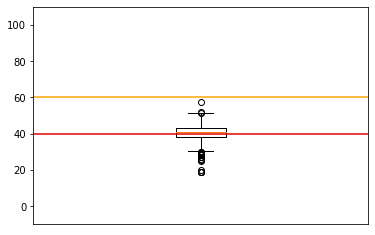


Current language: pl
Sample size for  too small

Current language: ar
Sample size for  too small

Current language: de
Sample size for  too small


In [19]:
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# # n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

langs = pd.Series(languages).unique()

for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
#     else:
#         break
        
    print("\nCurrent language: " + lang)

    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
    )


    texts_in_lang = []
    
    df_texts_in_lang = pd.DataFrame(columns = ["Text"])

    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
            texts_in_lang.append(file_text)
            df_texts_in_lang.loc[file.name] = file_text
            
    if len(texts_in_lang) < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue

    # --

    X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    
    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))

    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()

    X = X_lsa

    # eps=1.30 works well
    # 1.20 is where it starts to make to many clusters with just one element
    # 1.25 with min_samples=2 has a reasonable amount of outliers
    
    custom_eps = 1.10
    
    if lang == "it":
        custom_eps = 0.75 # 0.75 to 1.075 is a good range
                          # around 0.90 is a decent amount to find bad entries with noise
    elif lang == "en":
        custom_eps = 1.175
    
#     db = DBSCAN(eps=custom_eps, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
#     db = DBSCAN(eps=custom_eps, min_samples=1).fit(X)
    db = DBSCAN(eps=custom_eps, min_samples=2).fit(X) # Avoid singletons
    
    print("METRICS:")
    print(sklearn.metrics.pairwise.cosine_similarity(X, dense_output = True))

    print("Found " +  str(len(np.unique(db.labels_))) + " clusters")
    print("Labels: \n" + str(db.labels_))
    plt.bar(pd.Series(db.labels_).value_counts().keys(), pd.Series(db.labels_).value_counts())
    plt.savefig('images/clusterlabels' + lang + '.svg')
    plt.show()
    
    db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                                 "Text" : df_texts_in_lang.Text},
    #                              "Filename" : df_texts_in_lang.index},
                         index = df_texts_in_lang.index)
    db_df

    dissimilar_entries_urls = db_df.loc[db_df["Cluster"] != 0].index.tolist()
#     print(dissimilar_entries_urls) # Dissimilar entries
#     print(db_df.loc[db_df["Cluster"] == 0])

    # Print out each cluster
    for cluster in np.unique(db.labels_):
        cluster_content = db_df.loc[db_df["Cluster"] == cluster]["Text"]
        cluster_size = len(cluster_content)
        
        print("\nCluster: " + str(cluster) + " with " + str(cluster_size) + " elements")
        print(cluster_content)
        
        ## Make wordclouds for each cluster?
#         all_policy_text = ""
#         for policy_text in cluster_content:
#             all_policy_text += policy_text

#         wordcloud = WordCloud().generate(all_policy_text)

#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis("off")
#         plt.show()
        
        ## Readability analysis
        ar_readability_scores = []
        
        if lang == "en": ## Readability is only available in English and Italian
            # Set box plot scale
            plt.ylim(0, 100)
            
            hard_to_read = 0
            above_8th_grade = 0
            avg_grade_level = 0.0
            for policy_text in cluster_content:
                r = Readability(policy_text)
                fk = r.flesch_kincaid()
                grade_level = fk.grade_level

                avg_grade_level = avg_grade_level + float(grade_level)

                if int(grade_level) > 8:
                    above_8th_grade = above_8th_grade + 1

                if int(grade_level) > 18:
    #                 print(fk.grade_level)
                    hard_to_read = hard_to_read + 1
            
                ar_readability_scores.append(float(grade_level))

            avg_grade_level = round((avg_grade_level / len(cluster_content)), 1)

            print("\nHigher score is harder to read.\nHard to read texts: " + str(hard_to_read) + "\n" +
                "as a percentage of total: "  + str(round((100 * hard_to_read / len(cluster_content)), 1)) + "%\n" + 
                 "Average grade level: " + str(avg_grade_level) + "\n" +
                 "Texts above recommended level (8th grade) " + str(round((100 * above_8th_grade / len(cluster_content)), 1)) + "%")
        elif lang == "it":
            # Set box plot scale
            plt.ylim(-10, 110)
            
            hard_to_read = 0
            above_8th_grade = 0
            avg_gulpease_index = 0.0
            for policy_text in cluster_content:
                gulpease = textstat.gulpease_index(policy_text) # Lower is more complex

                avg_gulpease_index = avg_gulpease_index + float(gulpease)
                
                if int(gulpease) < 60:
                    above_8th_grade = above_8th_grade + 1
                    
                if gulpease < 40:
                    hard_to_read = hard_to_read + 1
            
                ar_readability_scores.append(float(gulpease))
                    
            avg_gulpease_index = round((avg_gulpease_index / len(cluster_content)), 1)
            
            print("\nHigher score is easier to read\nHard to read texts: " + str(hard_to_read) + "\n" +
                "as a percentage of total: "  + str(round((100 * hard_to_read / len(cluster_content)), 1)) + "%\n" + 
                 "Average gulpease index: " + str(avg_gulpease_index) + "\n" +
                 "Texts above recommended level (8th grade rough italian equivalent) " + str(round((100 * above_8th_grade / len(cluster_content)), 1)) + "%")
        
        print(ar_readability_scores)
        plt.boxplot(ar_readability_scores)
        plt.xticks([])
        plt.show()
            
        
        # Would probably be better to visualize these readability scores

        
    thresh_8th = 0
    thresh_hard = 0
        
    # Readability for whole language
    print("\n\nREADABILTY FOR WHOLE LANGUAGE " + lang)
    if lang == "en": ## Readability is only available in English and Italian
        # Set box plot scale
        plt.ylim(0, 40)
        
        thresh_8th = 8
        thresh_hard = 13 # Livello sopra il liceo

        hard_to_read = 0
        above_8th_grade = 0
        avg_grade_level = 0.0
        for policy_text in texts_in_lang:
            r = Readability(policy_text)
            fk = r.flesch_kincaid()
            grade_level = fk.grade_level

            avg_grade_level = avg_grade_level + float(grade_level)

            if int(grade_level) > thresh_8th:
                above_8th_grade = above_8th_grade + 1

            if int(grade_level) > thresh_hard:
#                 print(fk.grade_level)
                hard_to_read = hard_to_read + 1

            ar_readability_scores.append(float(grade_level))

        avg_grade_level = round((avg_grade_level / len(texts_in_lang)), 1)
        median_grade_level = np.median(ar_readability_scores)

        print("\nHigher score is harder to read.\nHard to read texts: " + str(hard_to_read) + "\n" +
            "as a percentage of total: "  + str(round((100 * hard_to_read / len(texts_in_lang)), 1)) + "%\n" + 
             "Average grade level: " + str(avg_grade_level) + "\n" +
             "Texts above recommended level (8th grade) " + str(round((100 * above_8th_grade / len(texts_in_lang)), 1)) + "%")
        print("Median score: " + str(median_grade_level))
    elif lang == "it":
            # Qui figura 7, indice gulpease su tutti i testi in italiano
            # Set box plot scale
            plt.ylim(-10, 110)
            
            thresh_8th = 60
            thresh_hard = 40
            
            hard_to_read = 0
            above_8th_grade = 0
            avg_gulpease_index = 0.0
            for policy_text in texts_in_lang:
#                 gulpease = textstat.gulpease_index(policy_text) # Lower is more complex
                gulpease = custom_gulpease(policy_text) # Lower is more complex
    
                if gulpease < 0:
                    print("Under 0")
                    print(policy_text)

                avg_gulpease_index = avg_gulpease_index + float(gulpease)
                
                if int(gulpease) < thresh_8th:
                    above_8th_grade = above_8th_grade + 1
                    
                if gulpease < thresh_hard:
                    hard_to_read = hard_to_read + 1
            
                ar_readability_scores.append(float(gulpease))
                    
            avg_gulpease_index = round((avg_gulpease_index / len(texts_in_lang)), 1)
            median_gulpease_index = np.median(ar_readability_scores)
            
            print("\nHigher score is easier to read\nHard to read texts: " + str(hard_to_read) + "\n" +
                "as a percentage of total: "  + str(round((100 * hard_to_read / len(texts_in_lang)), 1)) + "%\n" + 
                 "Average gulpease index: " + str(avg_gulpease_index) + "\n" +
                 "Texts above recommended level (8th grade rough italian equivalent) " + str(round((100 * above_8th_grade / len(texts_in_lang)), 1)) + "%")
            print("Median score: " + str(median_gulpease_index))
    
    plt.boxplot(ar_readability_scores)
    plt.axhline(y = thresh_8th, color = 'orange')
    plt.axhline(y = thresh_hard, color = '#E50000')
    plt.xticks([])
    plt.savefig('images/readabilitybox' + lang + '.svg')
    plt.show()
#     print("Found " + str(len(dissimilar_entries_urls)) + " dissimilar entries")



In [31]:
def cluster_center_by_cluster_label(cluster_query):
    cluster_vectors = []
    for i, l in enumerate(db.labels_):
        if l == cluster_query:
            cluster_vectors.append(X[i])

    # cluster_vectors = [[6,4,100], [0,0,0]]
    cluster_center = []
    for i in range (0, 100):
        avg = 0
        for cluster_element in cluster_vectors:
            avg = avg + cluster_element[i]

        cluster_center.append(avg/len(cluster_vectors))

    return cluster_center

In [32]:
def euc_distance(cluster_center1, cluster_center2):
    res = 0
    for i in range (100):
        res = res + ((cluster_center2[i] - cluster_center1[i]) ** 2)
    return math.sqrt(res)

def euc_distance_by_label(l1, l2):
    return euc_distance(cluster_center_by_cluster_label(c1), cluster_center_by_cluster_label(c2))

In [33]:
euc_distance(cluster_center_by_cluster_label(13), cluster_center_by_cluster_label(15))

1.2764790710349045

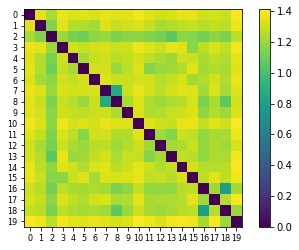

In [34]:
interesting_clusters = [8,16,1,6,11,37,39,57,61,64,7,18,27,31,51,23,60,69,41,62]

min_d = 100

d_m = []
for i, c1 in enumerate(interesting_clusters):
    d_m.append([])
    for c2 in interesting_clusters:
        if c1 != c2:
            d = euc_distance_by_label(c1, c2)
            if d < min_d:
                min_d = d
        else:
            d = 0.0
#         print("c1 " + str(c1) + ", c2 " + str(c2) + " d = " + str(d))
        d_m[i].append(d)

# d_norm = []
# for i, c1 in enumerate(interesting_clusters):
#     d_norm.append([])
#     for c2 in interesting_clusters:
#         if c1 != c2:
#             d = euc_distance_by_label(c1, c2) - min_d
#         else:
#             d = 0.0
# #         print("c1 " + str(c1) + ", c2 " + str(c2) + " d = " + str(d))
#         d_norm[i].append(d)

# import matplotlib
plt.imshow(d_m)
plt.xticks(np.arange(0, 20, step=1), fontsize = 8)
plt.yticks(np.arange(0, 20, step=1), fontsize = 8)
# plt.margins(0.2)
# plt.subplots_adjust(bottom=0.15)
plt.colorbar()
plt.savefig("images/clusterdistances.svg")
plt.show()

In [35]:
# db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
#                              "Text" : df_texts_in_lang.Text},
# #                              "Filename" : df_texts_in_lang.index},
#                      index = df_texts_in_lang.index)
# db_df

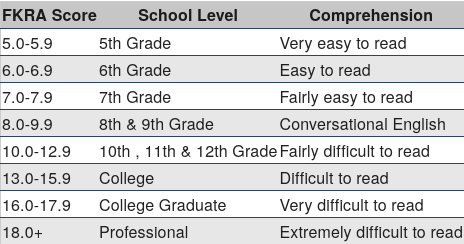

In [36]:
r = Readability(make_policy_files()[23].read())
fk = r.flesch_kincaid()
print(fk.score)
print(fk.grade_level) ## Higher is more complex

32.09167333470114
32


In [37]:
# db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

### 2.3 Wordcounts

it
521 total policies
Beware different scales!
Median wordcount: 1953.0
Max wordcount: 51160


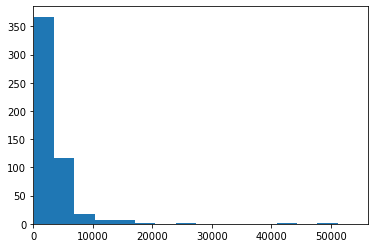

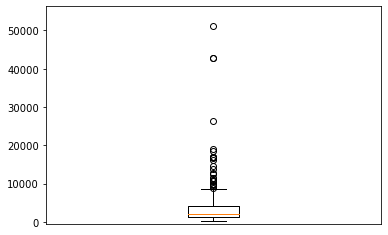

en
32 total policies
Beware different scales!
Median wordcount: 3513.5
Max wordcount: 15845


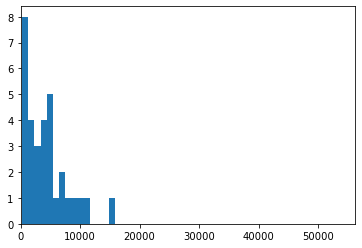

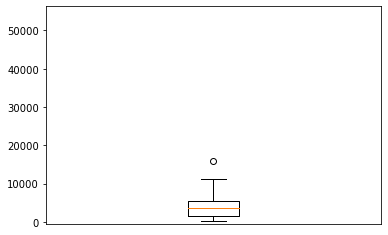

pl
1 total policies
Sample size for pl too small
ar
1 total policies
Sample size for ar too small
de
1 total policies
Sample size for de too small


In [38]:
# Simple analysis i.e. wordcount

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

highest_wordcount = 0
for file in policy_files:
    file_wordcount = len(file.read().split())
    if file_wordcount > highest_wordcount:
        highest_wordcount = file_wordcount

    
for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)
    total_policies_current_language = len(policy_files)
    print(str(total_policies_current_language) + " total policies")
    if total_policies_current_language < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue
    
    wordcounts = []
    max_wordcount = 0
    for file in policy_files:
        wc = len(file.read().split())
        wordcounts.append(wc)
        if wc > max_wordcount:
            max_wordcount = wc 

#     plt.ylim(0, 15)

#     plt.ylim(0, 300) # !!!
    print("Beware different scales!")
    
    median_wordcount = np.median(wordcounts)
    print("Median wordcount: " + str(median_wordcount))
    print("Max wordcount: " + str(max_wordcount))

    plt.xlim(0, highest_wordcount * 1.1)
    plt.hist(wordcounts, 15)
    plt.savefig('images/wordcounthist' + language + '.svg')
    plt.show()
    
    plt.ylim(-(highest_wordcount / 100), highest_wordcount * 1.1)
    plt.boxplot(wordcounts)
#     plt.axhline(y = 20000)
    plt.xticks([])
    plt.savefig('images/wordcountbox' + language + '.svg')
    plt.show()

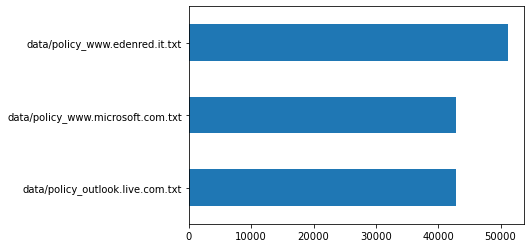

In [42]:
# Top 3 longest policies by wordcount overall

policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

wc_dict = {}

for file in policy_files:
    wc_dict[file.name] = len(file.read().split())
    
wc_s = pd.Series(wc_dict).sort_values(ascending=True)
wc_s[len(wc_s) - 3:].plot.barh()
plt.show()

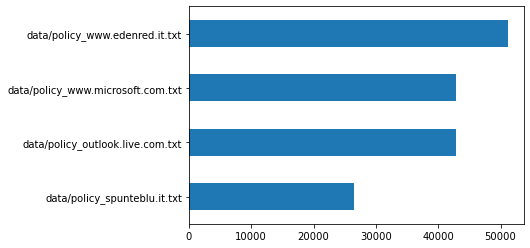

In [43]:
# longer than 20000 words
policy_files = make_policy_files()

wc_dict = {}

for file in policy_files:
    wc =  len(file.read().split())
    if wc > 20000:
        wc_dict[file.name] =wc
    
wc_s = pd.Series(wc_dict).sort_values(ascending=True)
wc_s.plot.barh()
plt.show()

In [44]:
wc_s[len(wc_s) - 3:]

data/policy_outlook.live.com.txt     42793
data/policy_www.microsoft.com.txt    42793
data/policy_www.edenred.it.txt       51160
dtype: int64

### 2.4 Wordclouds

In [ ]:
# Some fun wordclouds :)
# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))
    

for language in pd.Series(languages).value_counts().keys():
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))
    
    print(language)  
    
    if len(policy_files) < 10: # Ignore small sample sizes
        print("Sample size for " + language + " too small")
        continue
    
    if language == "it":
        stoplist_lang = "Italian"
    elif language == "en":
        stoplist_lang = "English"
    else:
        print("Not english or italian")
        continue

    all_policy_text = ""
    for file in policy_files:
        all_policy_text += file.read()

    wordcloud = WordCloud().generate(all_policy_text)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    # Unsurprisingly you have to filter out heaps of words...
#     policy_files = []
#     for filename in policy_file_names:
#         policy_files.append(open(DATADIR + filename))
    policy_files = []
    for filename in languages.keys():
        if languages[filename] == language:
            filename = filename[len("data/"):]
            policy_files.append(open(DATADIR + filename))

    all_policy_text_filtered = ""
    for file in policy_files:
        for word in file.read().split():
            if word not in (justext.get_stoplist(stoplist_lang)): # Those built in stoplists are kinda awful
                all_policy_text_filtered += word + " "

    wordcloud = WordCloud().generate(all_policy_text_filtered)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### 2.5 Emotion analysis

In [ ]:
# # Text2Emotion
# import text2emotion as t2e
# import emoji
# import nltk
# nltk.download('omw-1.4')

In [ ]:
# emotions_dict = {
#     "Angry" : 0,
#     "Fear" : 0,
#     "Happy" : 0,
#     "Sad" : 0,
#     "Surprise" : 0
# }

In [ ]:
# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))

In [ ]:
# for file in policy_files:
#     emotions = t2e.get_emotion(file.read())
#     top_emotion = max(emotions)
#     emotions_dict[top_emotion] = emotions_dict[top_emotion] + 1

# emotions_dict

In [ ]:
# emotions_dict = {
#     "Angry" : 0,
#     "Fear" : 0,
#     "Happy" : 0,
#     "Sad" : 0,
#     "Surprise" : 0
# }

# policy_files = []
# for filename in policy_file_names:
#     policy_files.append(open(DATADIR + filename))

# for file in policy_files:
#     emotions = t2e.get_emotion(file.read())
#     for emotion in emotions:
#         emotions_dict[emotion] = emotions_dict[emotion] + emotions[emotion] # maybe normalize?

# emotions_dict

In [ ]:
# for e in emotions_dict.keys():
#     emotions_dict[e] = round(emotions_dict[e] / len(policy_files), 3)

# emotions_dict

### 2.6 Text clustering

In [ ]:
policy_files = []
for filename in policy_file_names:
    policy_files.append(open(DATADIR + filename))

policy_texts = []

for file in policy_files:
    policy_texts.append(file.read())

df = pd.DataFrame(data = policy_texts, columns = ["Text"])
df

In [ ]:
# There should be a separation based on the policy's language

vec = TfidfVectorizer(stop_words = "english", ngram_range = (1, 3))
vec.fit(df.Text.values)
features = vec.transform(df.Text.values)

In [ ]:
clust = KMeans(init = "k-means++", n_clusters = 2, n_init = 10)

clust.fit(features)
yhat = clust.predict(features)
df['Cluster Labels'] = clust.labels_

# df.loc[df["Cluster Labels"] == 1]

In [ ]:
df_similar = pd.DataFrame(df.loc[df["Cluster Labels"] == 1].values)
# df_similar

In [ ]:
df_dissimilar = pd.DataFrame(df.loc[df["Cluster Labels"] == 0].values)
# df_dissimilar

In [ ]:
langs = pd.Series(languages).unique()

for lang in langs:
    print(lang)

In [ ]:
for lang in langs:
    language = ""
    
    if lang == "it":
        language = "italian"
    elif lang == "en":
        language = "english"
    else:
        break
        
    print("Current language: " + lang)

#     texts_in_lang = {}

    df_texts_in_lang = pd.DataFrame(columns = ["Text"])
    
    for file in make_policy_files():
        file_text = file.read()
        file_lang = langid.classify(file_text)[0]
        if file_lang == lang:
#             texts_in_lang.append(file_text)
#             texts_in_lang[file.name] = file_text
#             print(df_texts_in_lang)
#             df_texts_in_lang = df_texts_in_lang.append([file.name, file_text])
            df_texts_in_lang.loc[file.name] = file_text
    
#     print(texts_in_lang)
    
#     df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Filename", "Text"])

    lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))


    vectorizer = TfidfVectorizer(
        max_df=0.5,
        min_df=5,
#         stop_words="english",
    )

    try:
        X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)
    except ValueError:
        continue
    
    X_lsa = lsa.fit_transform(X_tfidf)
    explained_variance = lsa[0].explained_variance_ratio_.sum()


    kmeans = KMeans(
        n_clusters=2,
        max_iter=100,
        n_init=1,
    )

    kmeans.fit(X_lsa)

    original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
    order_centroids = original_space_centroids.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(2):
        print(f"Cluster {i}: ", end="")
        for ind in order_centroids[i, :10]:
            print(f"{terms[ind]} ", end="")
        print()

In [ ]:
df_texts_in_lang

In [ ]:
# df_texts_in_lang["Text"].index[2]

#### DBSCAN

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
)


texts_in_lang = []

for file in make_policy_files():
    file_text = file.read()
#     file_lang = langid.classify(file_text)[0]
#     if file_lang == lang:
    texts_in_lang.append(file_text)

# df_texts_in_lang = pd.DataFrame(data = texts_in_lang, columns = ["Text"])

# --

X_tfidf = vectorizer.fit_transform(df_texts_in_lang.Text)

X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

X = X_lsa

db = DBSCAN(eps=1, min_samples=len(df_texts_in_lang) // 10).fit(X) # each cluster must contain at lesast 1/10th of the total
# db.labels_

In [ ]:
db_df = pd.DataFrame(data = {"Cluster" : db.labels_,
                             "Text" : df_texts_in_lang.Text},
#                              "Filename" : df_texts_in_lang.index},
                     index = df_texts_in_lang.index)
db_df

In [ ]:
db_df.loc[db_df["Cluster"] == -1] # Dissimilar entries

In [ ]:
# import matplotlib.pyplot as plt

# # Black removed and is used for noise instead.
# labels = [0, -1]
# unique_labels = set(labels)
# colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

#     class_member_mask = labels == k
    
#     xy = X[class_member_mask & core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=14,
#     )

#     xy = X[class_member_mask & ~core_samples_mask]
#     plt.plot(
#         xy[:, 0],
#         xy[:, 1],
#         "o",
#         markerfacecolor=tuple(col),
#         markeredgecolor="k",
#         markersize=6,
#     )

# plt.title("Estimated number of clusters: %d" % n_clusters_)
# plt.show()

#### 2.6.2 Finer Clustering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(features)

def getind(c):
    return df[df.Text == c].index.tolist()

def gettext(i):
    return df[df.index == i].Text.tolist()

In [ ]:
similar = list(enumerate(cosine_sim[0]))
# similar

In [ ]:
# This one kinda does the same thing as the 2 clusters

sim_list = []
unsim_list = []
for m in similar:
    t = gettext(m[0])
    if m[1] > 0.15:
        sim_list.append(t)
    else:
        unsim_list.append(t)

In [ ]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [ ]:
# df_sim

In [ ]:
# df_unsim

In [ ]:
cosim = list(enumerate(cosine_sim))
cumulative_sim = []

for entry in cosim:
    cumulative_sim.append(0)

for entry in cosim:
    i = 0
    for sim_value in entry[1]:
        cumulative_sim[i] = cumulative_sim[i] + (sim_value / len(cosim)) # Normalization
        
        i = i + 1

In [ ]:
plt.plot(cumulative_sim)

In [ ]:
sim_list = []
unsim_list = []

threshold = 0.085

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        sim_list.append(t)
    else:
        unsim_list.append(t)
    i = i + 1

In [ ]:
df_sim = pd.DataFrame(sim_list, columns = ["Text"])
df_unsim = pd.DataFrame(unsim_list, columns = ["Text"])

In [ ]:
# df_sim

In [ ]:
# df_unsim

In [ ]:
verysim_list = []

threshold = 0.185

i = 0
for k in cumulative_sim:
    t = gettext(i)
    if k > threshold:
        verysim_list.append(t)
#     else:
#         unsim_list.append(t)
    i = i + 1

In [ ]:
df_verysim = pd.DataFrame(verysim_list, columns = ["Text"])
df_verysim